# Introduction

    In this project, we will be using patient health data from MIT's GOSSIS(Global Open Source Severity of Illness Score) to do an experiment, in which we want to evaluate the question of which modeling strategy leads to the most effective predictions. The training dataset contains 91713 entries and 186 variables including age, gender, height etc. There are 5 models chosen, KNN, Logsitic Regression, Random Forest, Boosting Models, and Neural Networks.For one model approach, we are training and testing on the whole dataset. For the many model approach, we are training and testing the model on 5 age subgroups of dataset. The goal is to test which approach performs better.
    
    There are in toal 5 parts in this project, data preprocessing, Adversarial Validation, data modeling(One-Model approach, Many-Model approach), scoreboard, disscusion and references. 
    
    In the data preprocessing part, first, I decide to delete varibles having no or very few repeated values. Second, the percentage of missing values higher than 80%. After that, I check the missing values in train and test data, categorical and numeri variables separately, and fill the NAs according to the pattern, with the first type of categorical variable, or adding a type of 'missing', or 0, or median, or random, or mean. 
    
    In the Adversarial validation part, I use the cleaned data obtained from above process, and predict the results with random forest, which returns a roc_auc of nearly 50%.
    
    Then in the data modeling parts, models used are listed above. Scores are listed in the scoreboard. Discussion is about my findings during the whole process. At last is the references.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import missingno as msno
from scipy import stats

In [429]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Data Preprocessing

In [192]:
train = pd.read_csv('/Users/weiyizhong/Downloads/Columbia/widsdatathon2020/training_v2.csv')
test = pd.read_csv('/Users/weiyizhong/Downloads/Columbia/widsdatathon2020/unlabeled.csv')

print(train.shape)
print(test.shape)

train.head()

(91713, 186)
(39308, 186)


encounter_id  patient_id  hospital_id  hospital_death   age    bmi  \
0         66154       25312          118               0  68.0  22.73   
1        114252       59342           81               0  77.0  27.42   
2        119783       50777          118               0  25.0  31.95   
3         79267       46918          118               0  81.0  22.64   
4         92056       34377           33               0  19.0    NaN   

   elective_surgery  ethnicity gender  height  ... aids cirrhosis  \
0                 0  Caucasian      M   180.3  ...  0.0       0.0   
1                 0  Caucasian      F   160.0  ...  0.0       0.0   
2                 0  Caucasian      F   172.7  ...  0.0       0.0   
3                 1  Caucasian      F   165.1  ...  0.0       0.0   
4                 0  Caucasian      M   188.0  ...  0.0       0.0   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               0.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  
0                          0.0                Sepsis       Cardiovascular  
1                          0.0           Respiratory          Respiratory  
2                          0.0             Metabolic            Metabolic  
3                          0.0        Cardiovascular       Cardiovascular  
4                          0.0                Trauma               Trauma  

[5 rows x 186 columns]

In [193]:
test.head()

encounter_id  patient_id  hospital_id  hospital_death   age        bmi  \
0             2      127112            7             NaN  56.0  21.102439   
1             5      130737          178             NaN   NaN  19.500595   
2             7      101458           86             NaN  66.0  32.518596   
3             8       48067          163             NaN  64.0  20.798520   
4            10       25865           59             NaN  56.0        NaN   

   elective_surgery         ethnicity gender  height  ... aids cirrhosis  \
0                 0         Caucasian      M   180.3  ...  0.0       0.0   
1                 1         Caucasian      F   145.0  ...  0.0       0.0   
2                 1  African American      M   170.2  ...  0.0       0.0   
3                 0         Caucasian      M   182.8  ...  0.0       0.0   
4                 0         Caucasian      M     NaN  ...  0.0       0.0   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                0.0             0.0               0.0       0.0       0.0   
1                0.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               1.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  
0                          0.0          Neurological           Neurologic  
1                          0.0          Neurological           Neurologic  
2                          0.0        Cardiovascular       Cardiovascular  
3                          0.0           Respiratory          Respiratory  
4                          0.0          Neurological           Neurologic  

[5 rows x 186 columns]

In [194]:
## combine two datasets to process varibles efficiently
combined_df = pd.concat(objs = [train, test], axis=0)
combined_df.shape

(131021, 186)

In [54]:
## we found that after concatnation, the hospital_death becomes float type
combined_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131021 entries, 0 to 39307
Data columns (total 186 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   encounter_id                   int64  
 1   patient_id                     int64  
 2   hospital_id                    int64  
 3   hospital_death                 float64
 4   age                            float64
 5   bmi                            float64
 6   elective_surgery               int64  
 7   ethnicity                      object 
 8   gender                         object 
 9   height                         float64
 10  hospital_admit_source          object 
 11  icu_admit_source               object 
 12  icu_id                         int64  
 13  icu_stay_type                  object 
 14  icu_type                       object 
 15  pre_icu_los_days               float64
 16  readmission_status             int64  
 17  weight                         float64
 18  albu

In [55]:
combined_df.hospital_death

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
39303    NaN
39304    NaN
39305    NaN
39306    NaN
39307    NaN
Name: hospital_death, Length: 131021, dtype: float64

## 1.1 Unique Values -- whole dataset

In [197]:
## since a varible with all unique values cant be used for prediction, therefore we could drop them
## if all the values are unique, the number would be 131021, which is the length of the df.
## also should consider the case when there are two values are identical, saying, the uniue values are 131020
list_unique=[]
for i in combined_df.columns:
    print(str(i) + ":"+ "\n" + str(combined_df[i].nunique()))
    if(combined_df[i].nunique() == 131021 or combined_df[i].nunique() == 131020):
        list_unique.append(i)
    print(list_unique)
        

encounter_id:
131021
['encounter_id']
patient_id:
131021
['encounter_id', 'patient_id']
hospital_id:
204
['encounter_id', 'patient_id']
hospital_death:
2
['encounter_id', 'patient_id']
age:
74
['encounter_id', 'patient_id']
bmi:
41622
['encounter_id', 'patient_id']
elective_surgery:
2
['encounter_id', 'patient_id']
ethnicity:
6
['encounter_id', 'patient_id']
gender:
2
['encounter_id', 'patient_id']
height:
445
['encounter_id', 'patient_id']
hospital_admit_source:
15
['encounter_id', 'patient_id']
icu_admit_source:
5
['encounter_id', 'patient_id']
icu_id:
328
['encounter_id', 'patient_id']
icu_stay_type:
3
['encounter_id', 'patient_id']
icu_type:
8
['encounter_id', 'patient_id']
pre_icu_los_days:
11380
['encounter_id', 'patient_id']
readmission_status:
1
['encounter_id', 'patient_id']
weight:
3640
['encounter_id', 'patient_id']
albumin_apache:
36
['encounter_id', 'patient_id']
apache_2_diagnosis:
44
['encounter_id', 'patient_id']
apache_3j_diagnosis:
400
['encounter_id', 'patient_id']
a

In [198]:
## we drop these variables with all unique values
## assign it to a new df
combined_df1 = combined_df.drop(columns = ['encounter_id', 'patient_id'])
combined_df1.shape

(131021, 184)

In [199]:
combined_df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131021 entries, 0 to 39307
Data columns (total 184 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   hospital_id                    int64  
 1   hospital_death                 float64
 2   age                            float64
 3   bmi                            float64
 4   elective_surgery               int64  
 5   ethnicity                      object 
 6   gender                         object 
 7   height                         float64
 8   hospital_admit_source          object 
 9   icu_admit_source               object 
 10  icu_id                         int64  
 11  icu_stay_type                  object 
 12  icu_type                       object 
 13  pre_icu_los_days               float64
 14  readmission_status             int64  
 15  weight                         float64
 16  albumin_apache                 float64
 17  apache_2_diagnosis             float64
 18  apac

## 1.2 Missing Values -- whole dataset

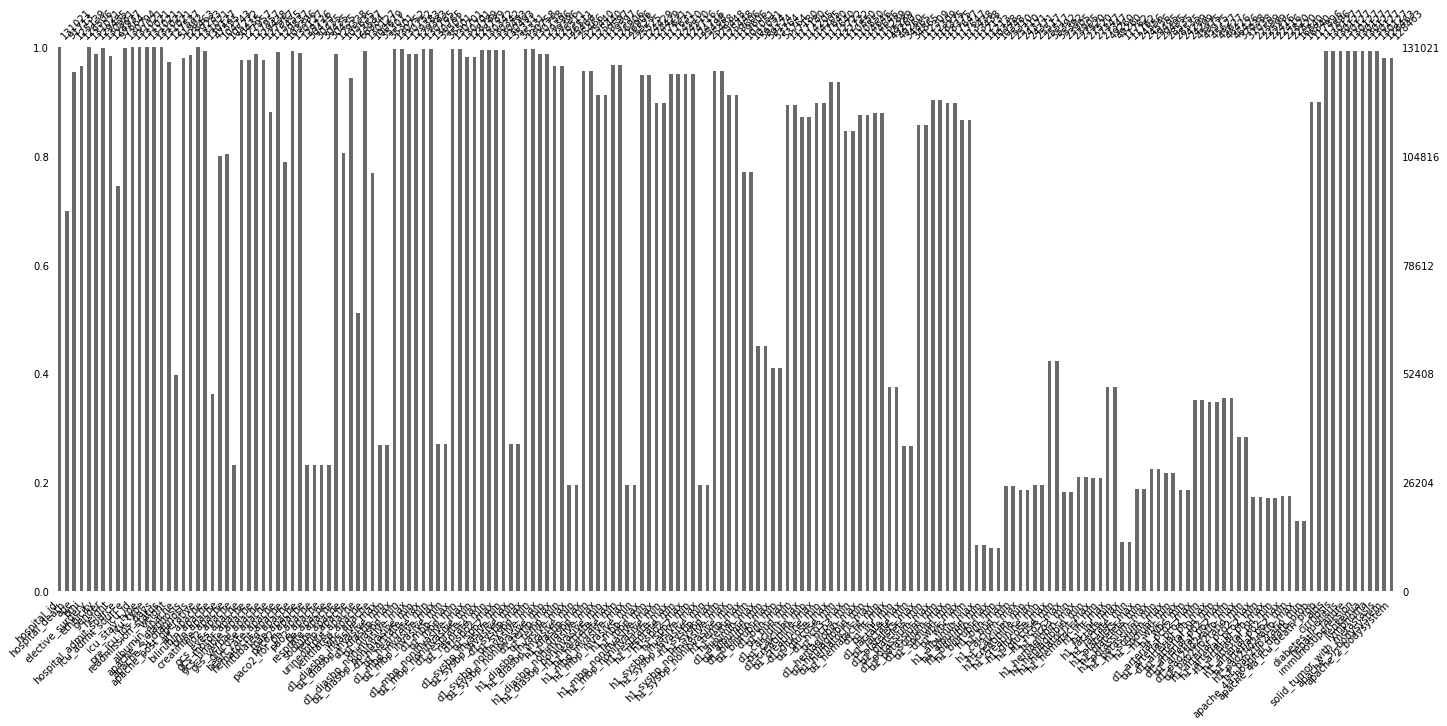

In [49]:
# using missingno to see na distribution in the train dataset
msno.bar(combined_df1, labels = True, fontsize = 10)

In [200]:
## calculate the percentage of missing valus in each column of train dataset
## maintain a list of varibles with >=80% NAs
list_to_drop = []
for col in combined_df1.columns:
    print(col + ": " + str(combined_df1[col].isna().sum()) + ", "+ str(round(((combined_df1[col].isna().sum())/len(combined_df1)),2)))
    if(round(((combined_df1[col].isna().sum())/len(combined_df1)),2) >= 0.8):
        list_to_drop.append(col)
list_to_drop

hospital_id: 0, 0.0
hospital_death: 39308, 0.3
age: 5882, 0.04
bmi: 4515, 0.03
elective_surgery: 0, 0.0
ethnicity: 1566, 0.01
gender: 40, 0.0
height: 2084, 0.02
hospital_admit_source: 33357, 0.25
icu_admit_source: 227, 0.0
icu_id: 0, 0.0
icu_stay_type: 0, 0.0
icu_type: 0, 0.0
pre_icu_los_days: 0, 0.0
readmission_status: 0, 0.0
weight: 3484, 0.03
albumin_apache: 79029, 0.6
apache_2_diagnosis: 2558, 0.02
apache_3j_diagnosis: 1738, 0.01
apache_post_operative: 0, 0.0
arf_apache: 894, 0.01
bilirubin_apache: 83426, 0.64
bun_apache: 26278, 0.2
creatinine_apache: 25749, 0.2
fio2_apache: 100586, 0.77
gcs_eyes_apache: 3064, 0.02
gcs_motor_apache: 3064, 0.02
gcs_unable_apache: 1583, 0.01
gcs_verbal_apache: 3064, 0.02
glucose_apache: 15566, 0.12
heart_rate_apache: 1184, 0.01
hematocrit_apache: 27625, 0.21
intubated_apache: 894, 0.01
map_apache: 1295, 0.01
paco2_apache: 100586, 0.77
paco2_for_ph_apache: 100586, 0.77
pao2_apache: 100586, 0.77
ph_apache: 100586, 0.77
resprate_apache: 1683, 0.01
sodiu

['h1_diasbp_invasive_max',
 'h1_diasbp_invasive_min',
 'h1_mbp_invasive_max',
 'h1_mbp_invasive_min',
 'h1_sysbp_invasive_max',
 'h1_sysbp_invasive_min',
 'h1_albumin_max',
 'h1_albumin_min',
 'h1_bilirubin_max',
 'h1_bilirubin_min',
 'h1_bun_max',
 'h1_bun_min',
 'h1_calcium_max',
 'h1_calcium_min',
 'h1_creatinine_max',
 'h1_creatinine_min',
 'h1_hco3_max',
 'h1_hco3_min',
 'h1_lactate_max',
 'h1_lactate_min',
 'h1_platelets_max',
 'h1_platelets_min',
 'h1_wbc_max',
 'h1_wbc_min',
 'h1_arterial_pco2_max',
 'h1_arterial_pco2_min',
 'h1_arterial_ph_max',
 'h1_arterial_ph_min',
 'h1_arterial_po2_max',
 'h1_arterial_po2_min',
 'h1_pao2fio2ratio_max',
 'h1_pao2fio2ratio_min']

In [201]:
## drop varibles with >=80% NAs
for i in list_to_drop:
    combined_df1 = combined_df1.drop(columns = [i], axis = 1)

In [203]:
## drop na of age
combined_df1 =  combined_df1.dropna(subset=['age'])

In [204]:
combined_df1.age.isna().sum()

0

In [205]:
## check the whole data
pd.set_option("display.max_rows",200)
print(combined_df1.shape)
combined_df1.isna().sum()

(125139, 152)


hospital_id                          0
hospital_death                   37654
age                                  0
bmi                               4278
elective_surgery                     0
ethnicity                         1500
gender                              22
height                            1963
hospital_admit_source            31849
icu_admit_source                   221
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
readmission_status                   0
weight                            3303
albumin_apache                   74967
apache_2_diagnosis                1616
apache_3j_diagnosis                802
apache_post_operative                0
arf_apache                           0
bilirubin_apache                 79122
bun_apache                       24254
creatinine_apache                23734
fio2_apache                      95505
gcs_eyes_apache          

## 1.3 Check missing values -- train and test

In [206]:
## check rest of the NAs of numeric varibles in train and test
import copy
train1 = copy.copy(combined_df1[:len(train)])
test1 = copy.copy(combined_df1[len(train):])
print(train1.shape)
print(test1.shape)

(91713, 152)
(33426, 152)


In [207]:
train1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91713 entries, 0 to 4385
Data columns (total 152 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   hospital_id                    int64  
 1   hospital_death                 float64
 2   age                            float64
 3   bmi                            float64
 4   elective_surgery               int64  
 5   ethnicity                      object 
 6   gender                         object 
 7   height                         float64
 8   hospital_admit_source          object 
 9   icu_admit_source               object 
 10  icu_id                         int64  
 11  icu_stay_type                  object 
 12  icu_type                       object 
 13  pre_icu_los_days               float64
 14  readmission_status             int64  
 15  weight                         float64
 16  albumin_apache                 float64
 17  apache_2_diagnosis             float64
 18  apache

### 1.3.1 Missing values among numeric varibles

In [208]:
## check numeric varibles pattern
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']


number_train = train1.select_dtypes(include=numerics)
number_test = test1.select_dtypes(include=numerics)

def plot_numeric(train_num_column, test_num_column):  
    sns.distplot(train1[train_num_column], color='b')
    plt.title("train_" + train_num_column)
    plt.show()

    sns.distplot(test1[test_num_column], color='b')
    plt.title("test_" + test_num_column)
    plt.show()

In [209]:
train_col_list = []
test_col_list = []

for col in number_train.columns:
    train_col_list.append(col)

for col in number_test.columns:
    test_col_list.append(col)

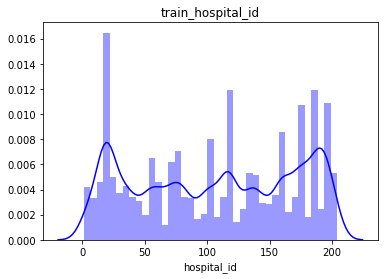

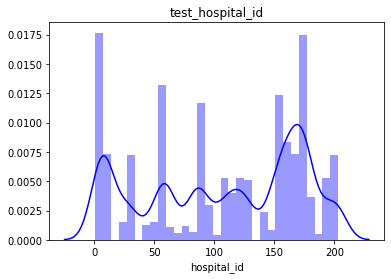

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


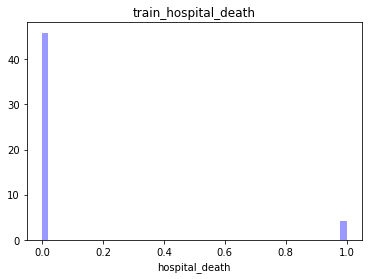

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


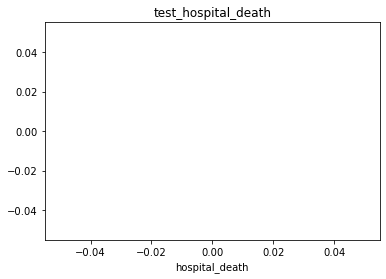

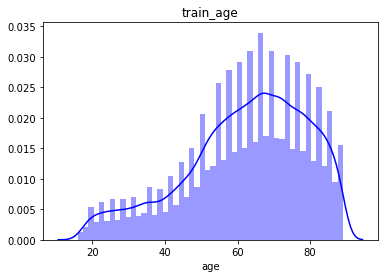

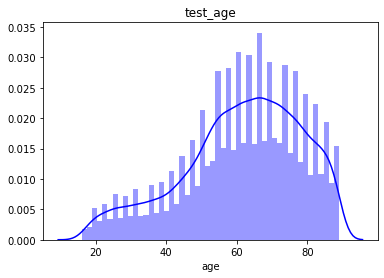

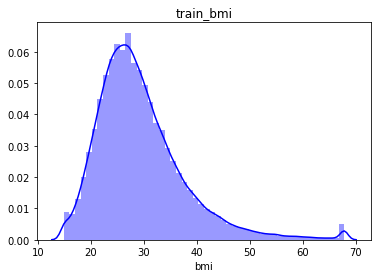

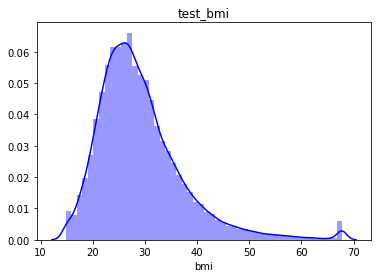

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


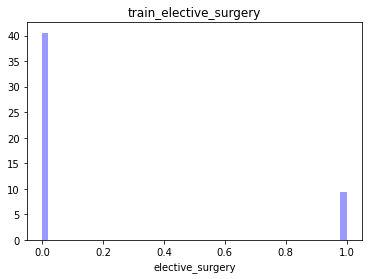

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


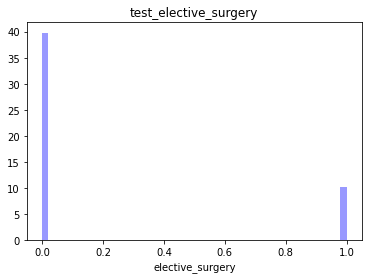

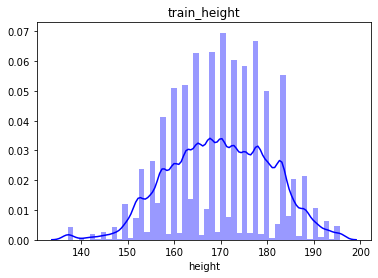

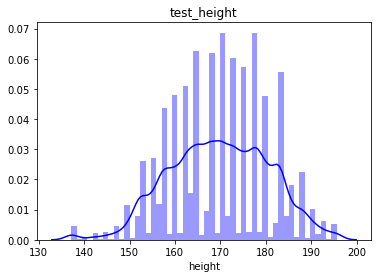

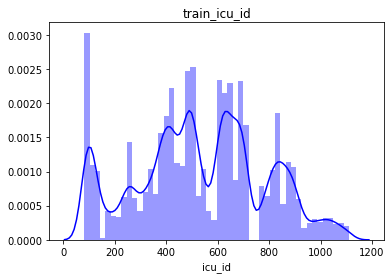

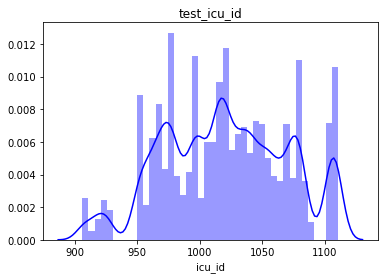

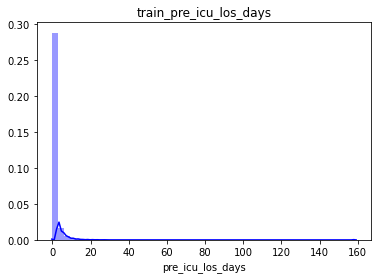

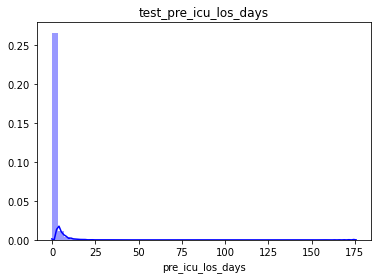

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


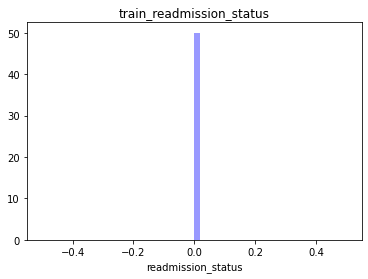

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


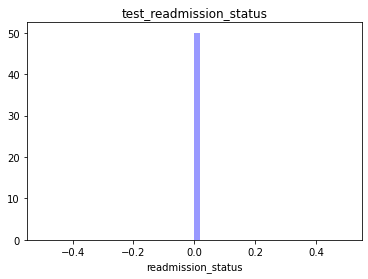

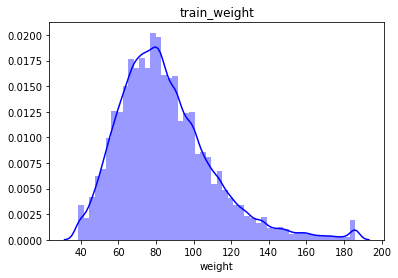

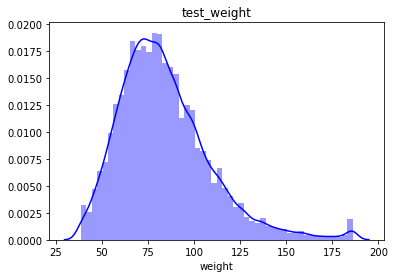

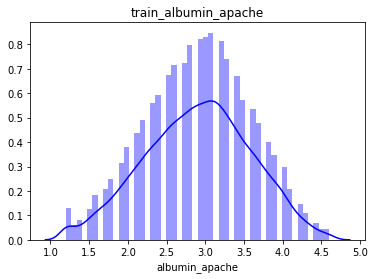

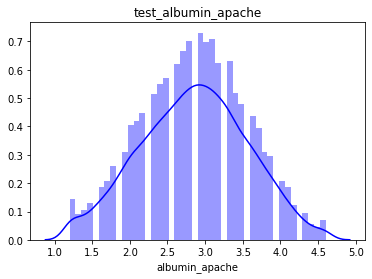

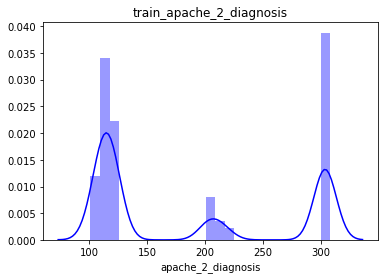

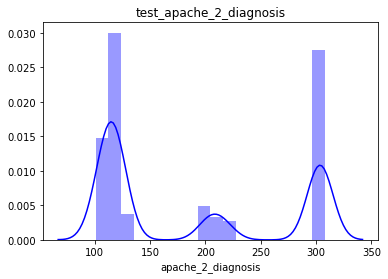

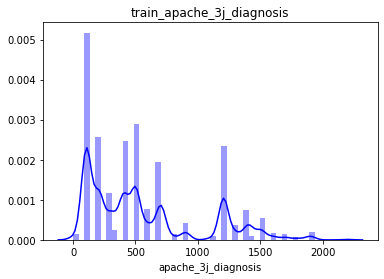

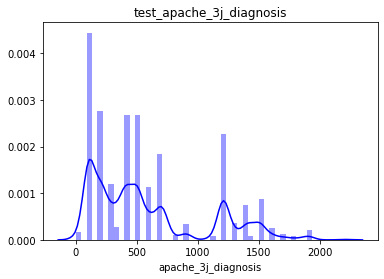

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


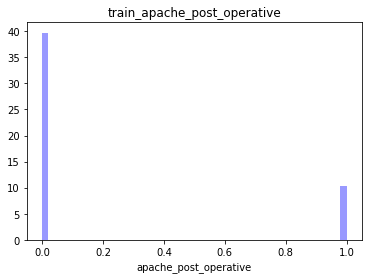

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


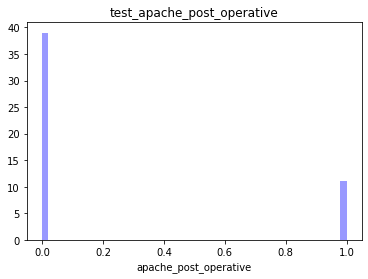

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


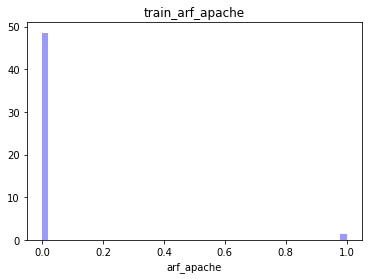

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


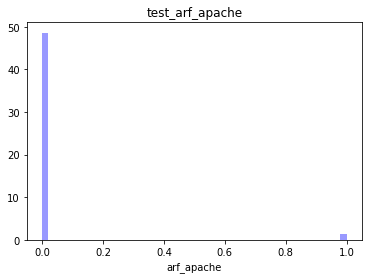

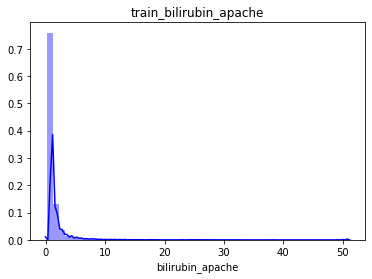

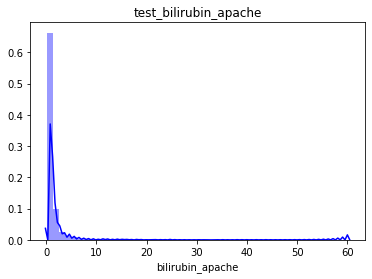

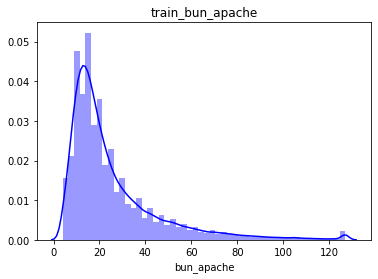

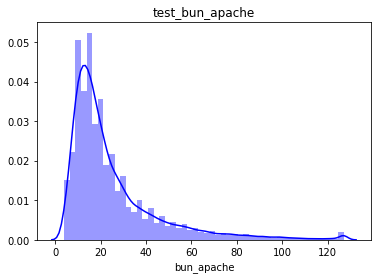

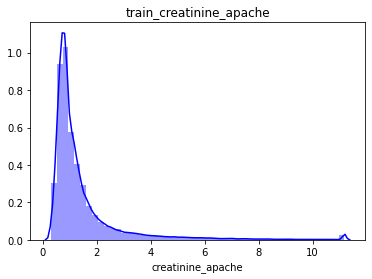

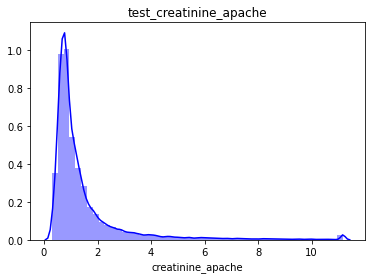

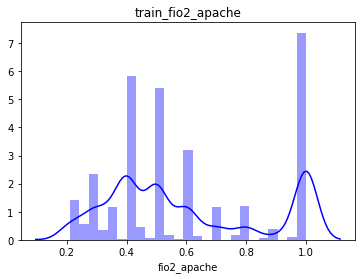

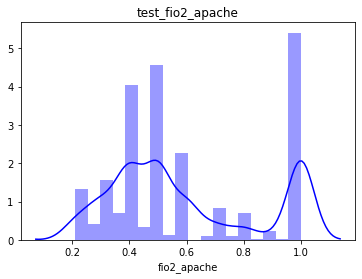

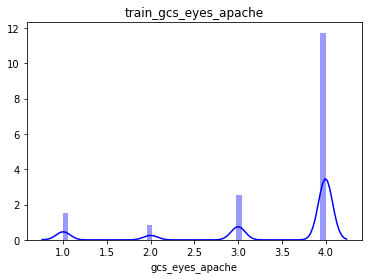

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


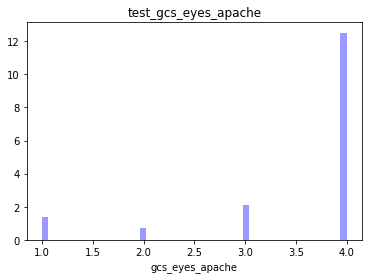

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


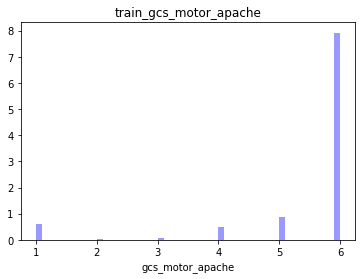

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


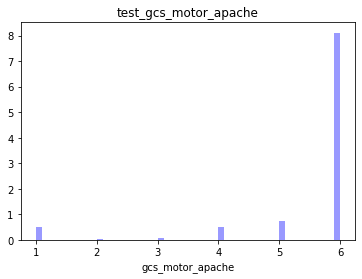

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


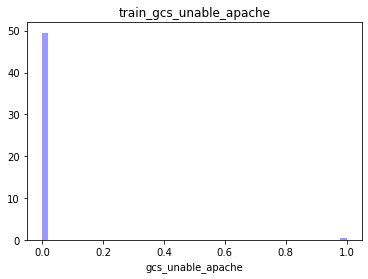

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


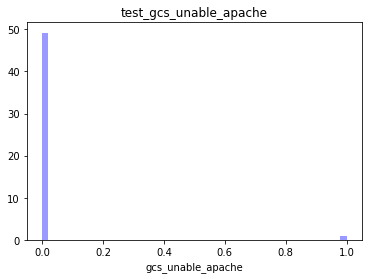

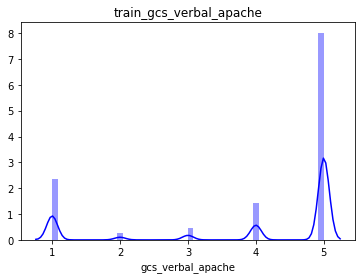

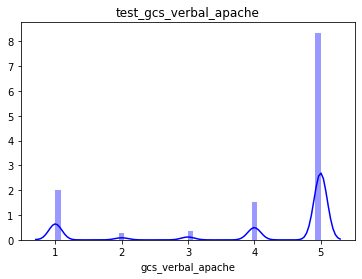

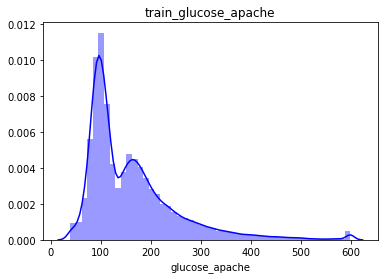

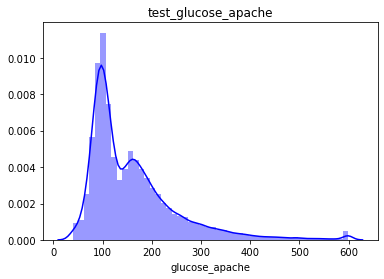

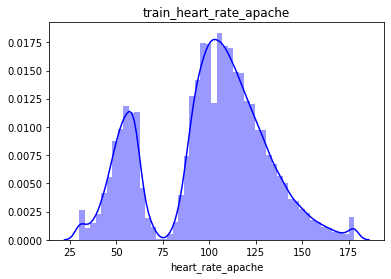

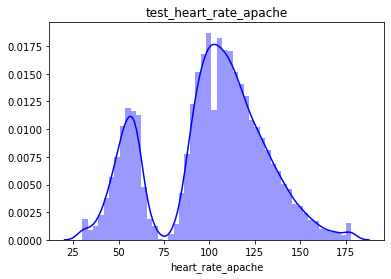

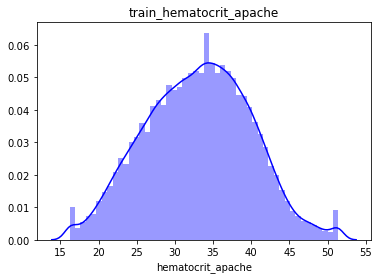

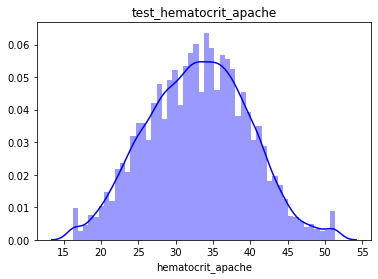

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


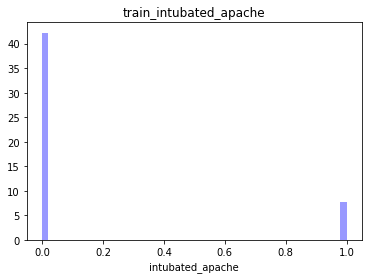

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


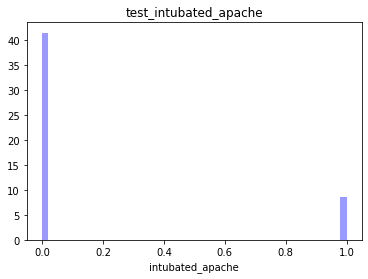

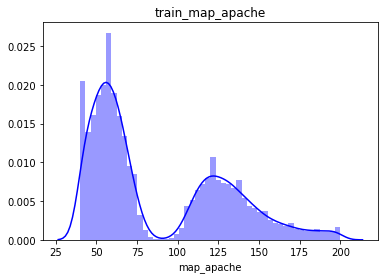

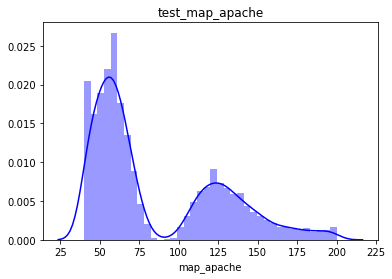

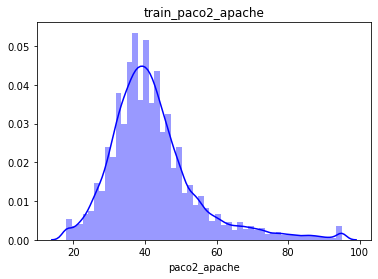

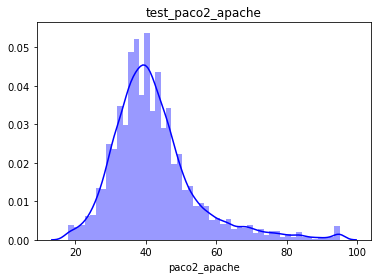

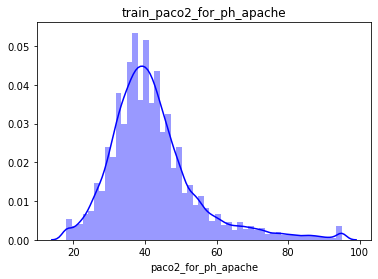

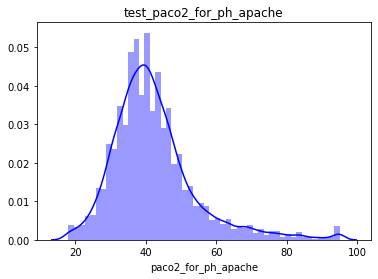

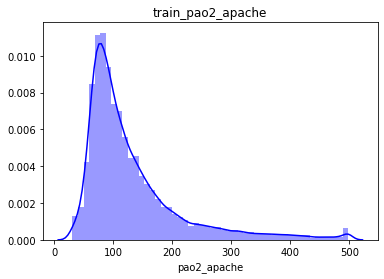

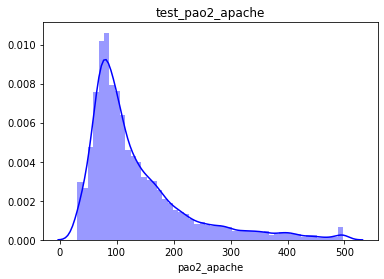

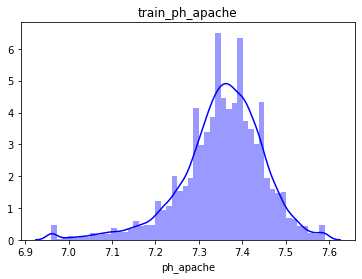

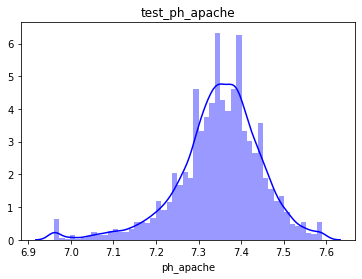

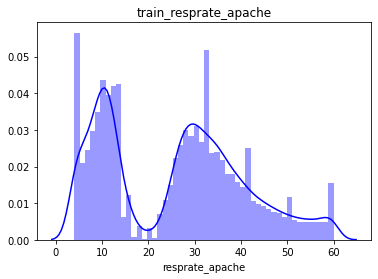

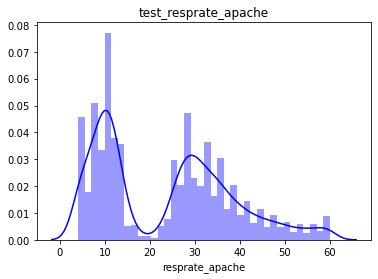

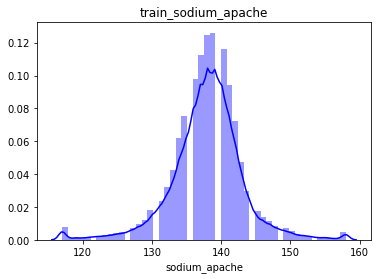

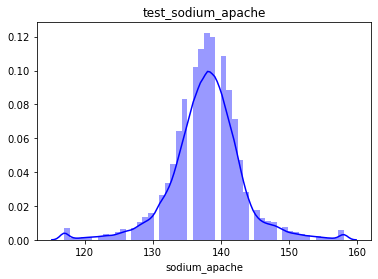

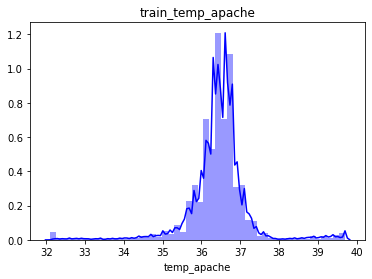

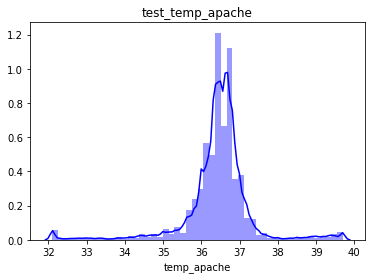

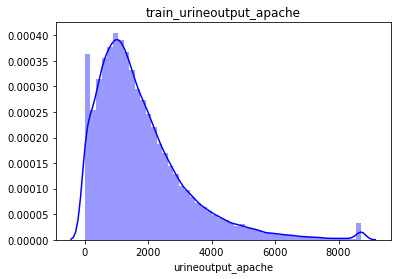

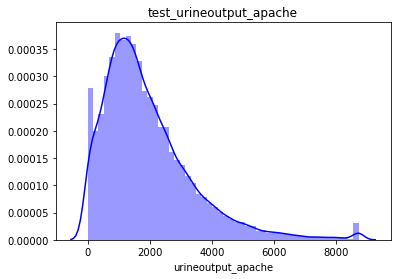

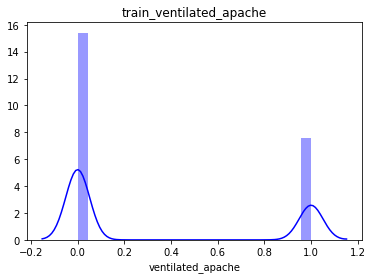

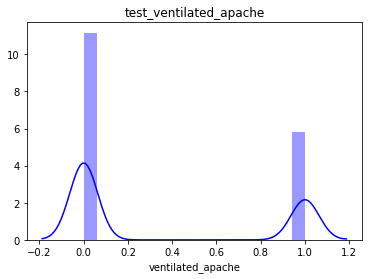

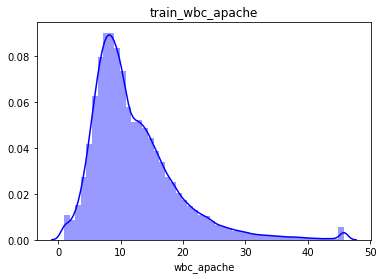

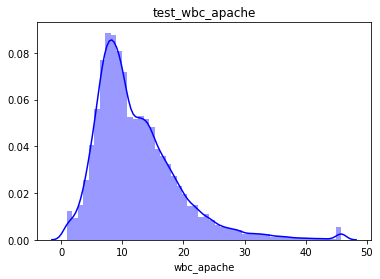

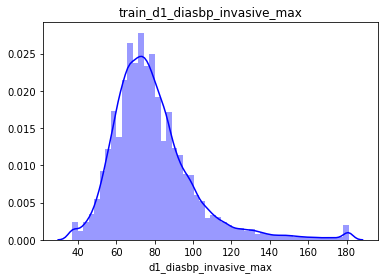

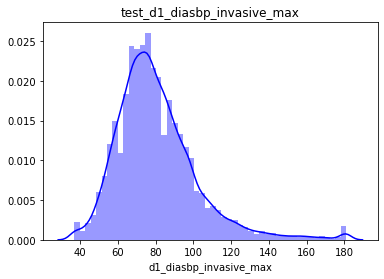

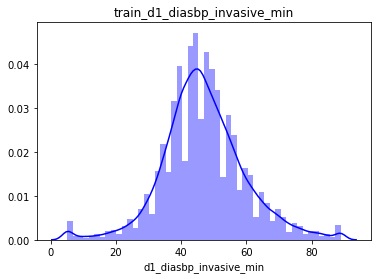

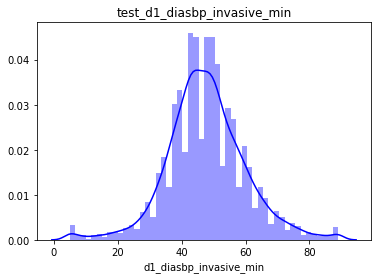

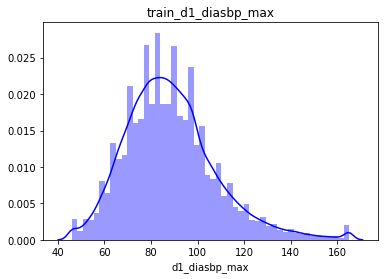

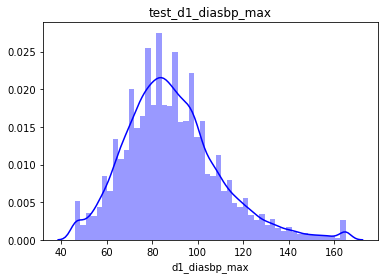

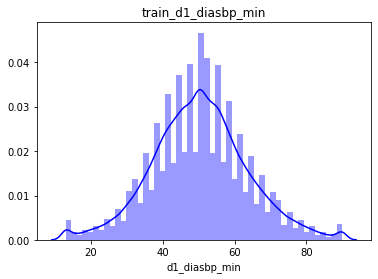

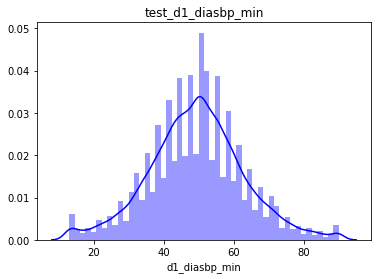

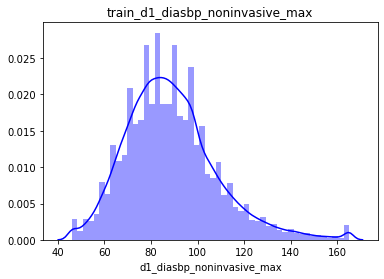

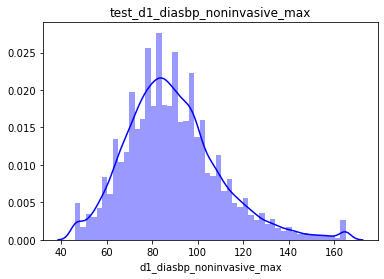

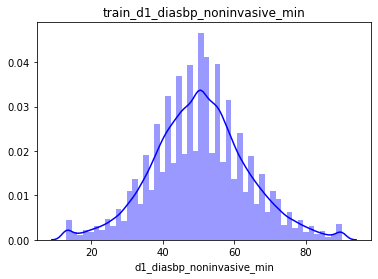

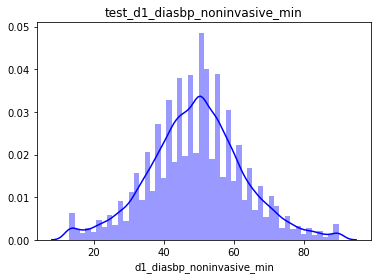

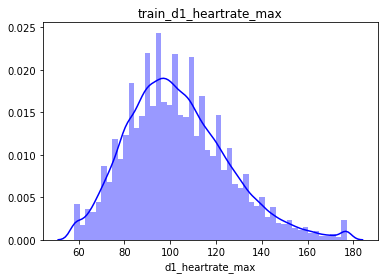

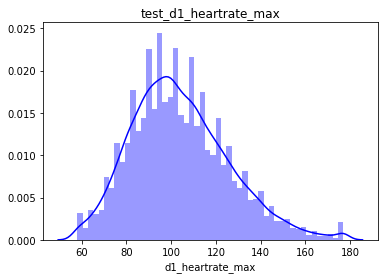

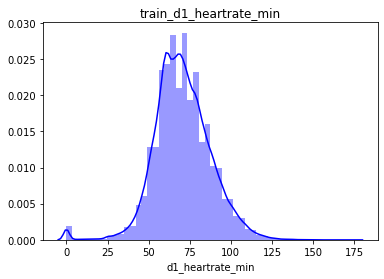

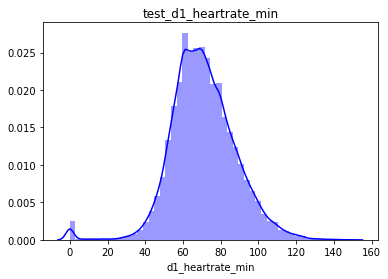

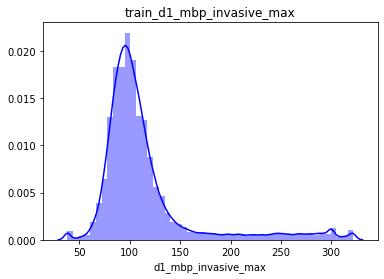

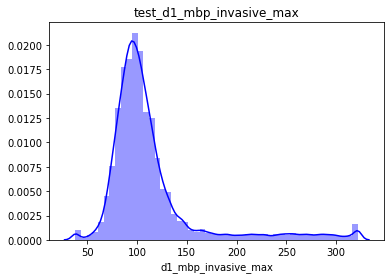

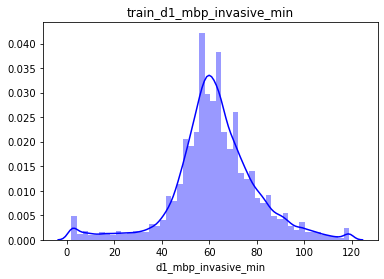

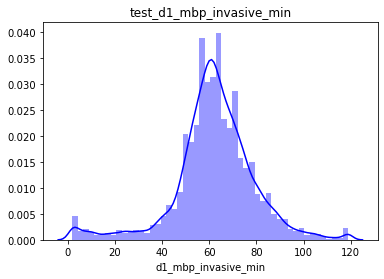

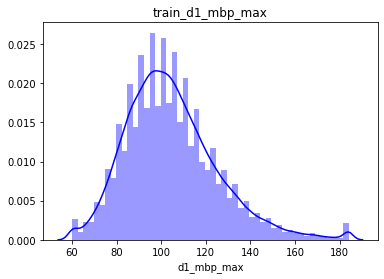

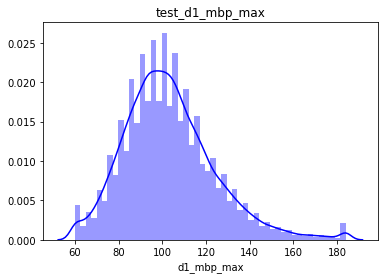

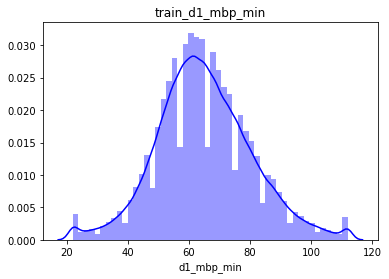

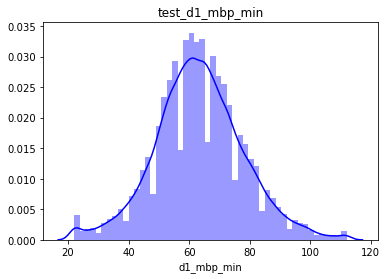

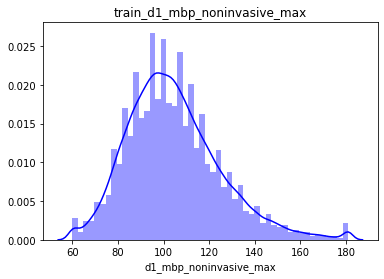

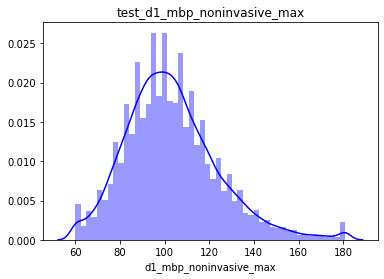

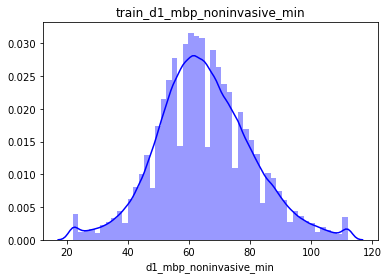

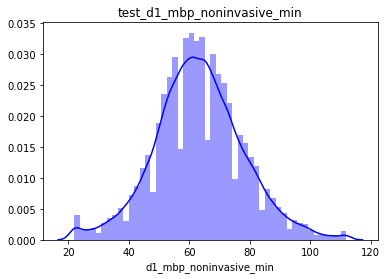

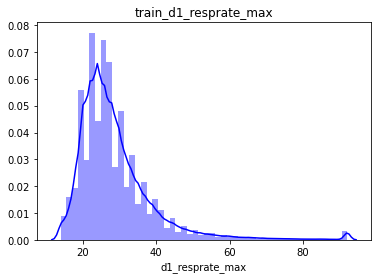

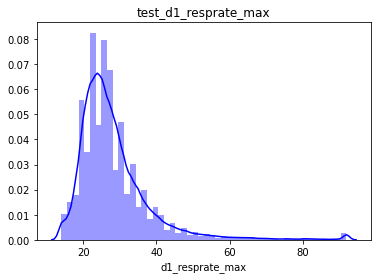

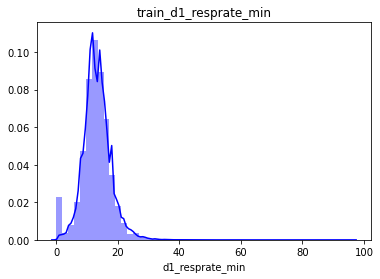

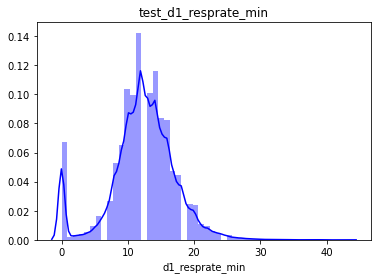

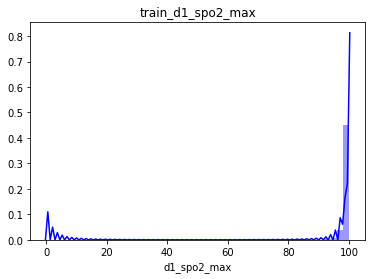

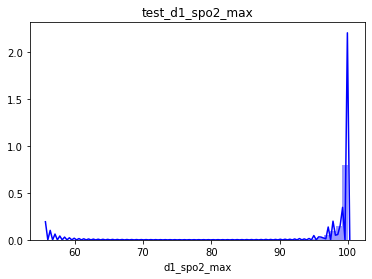

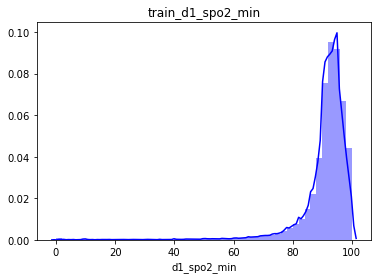

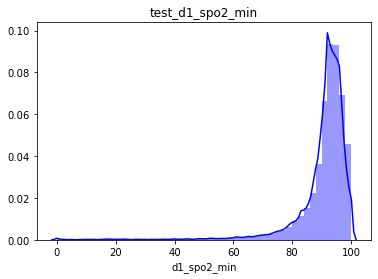

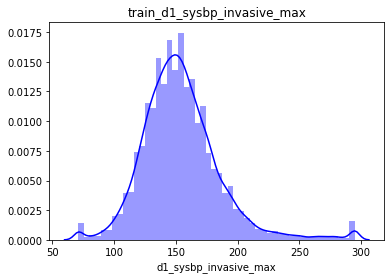

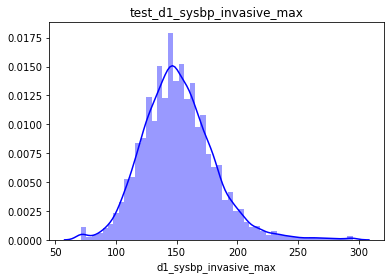

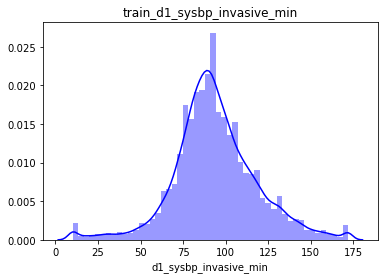

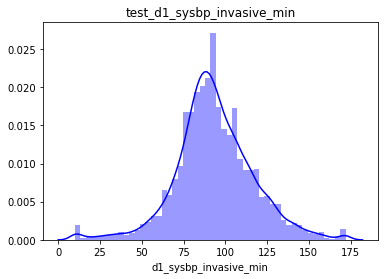

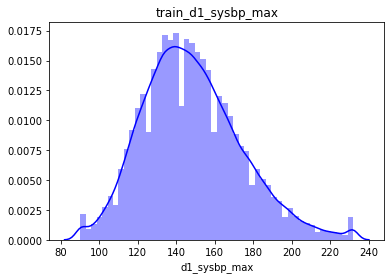

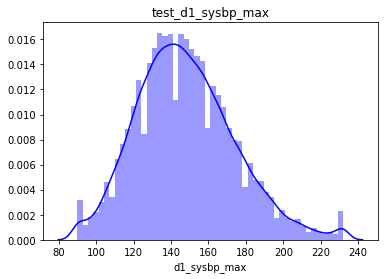

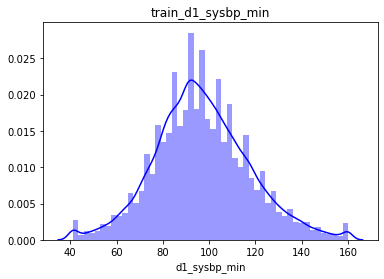

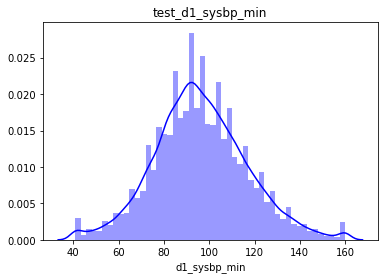

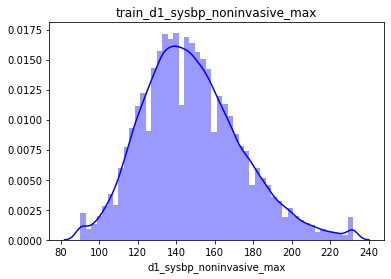

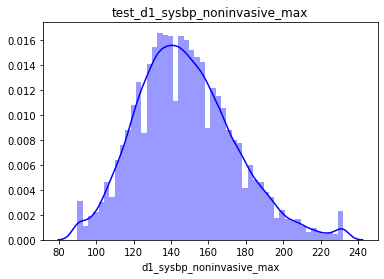

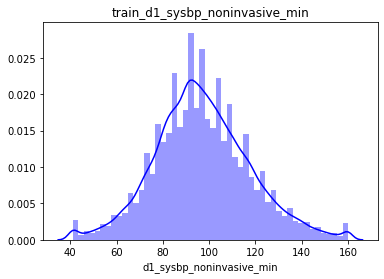

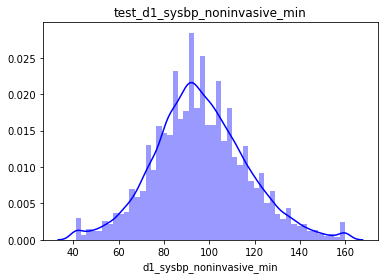

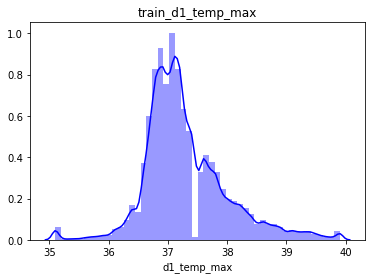

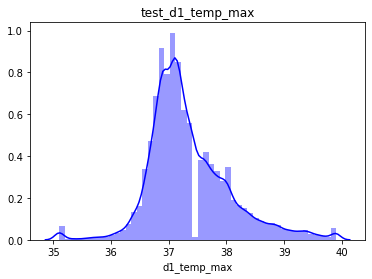

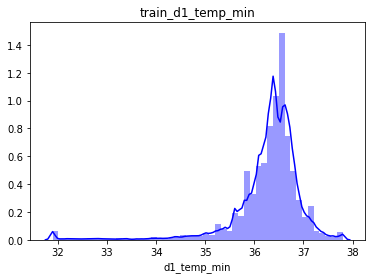

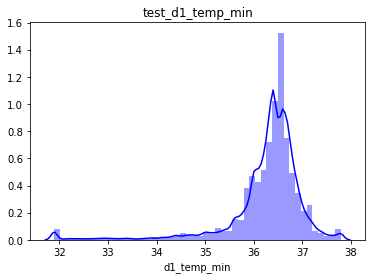

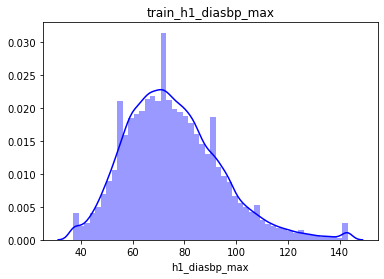

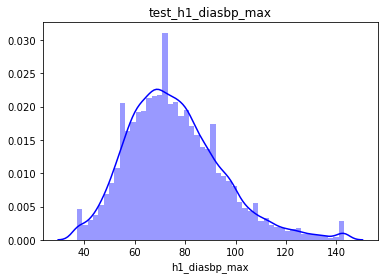

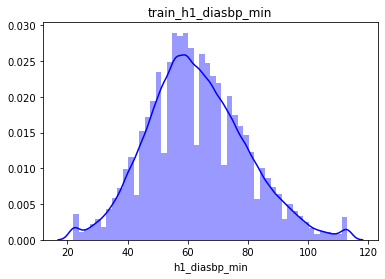

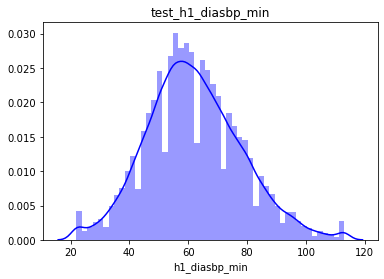

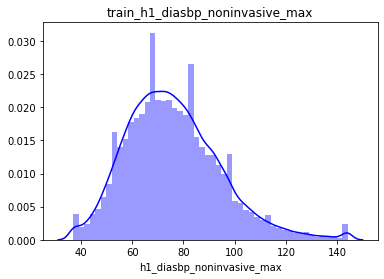

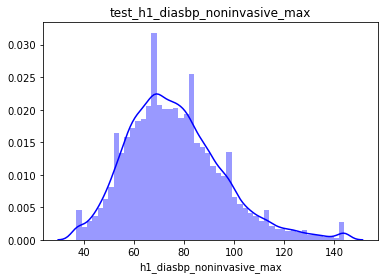

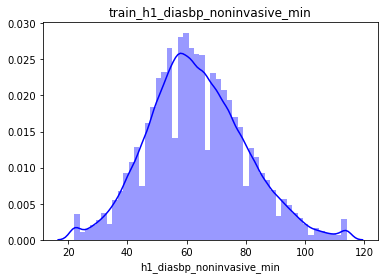

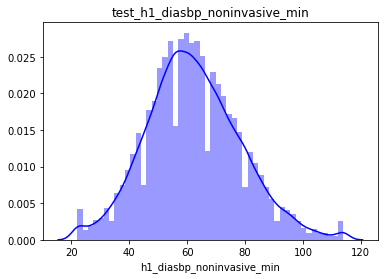

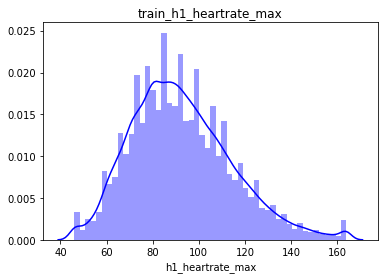

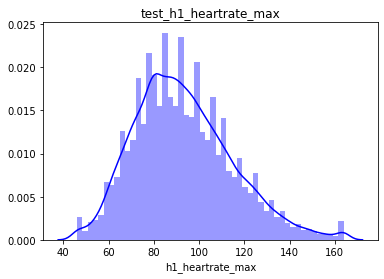

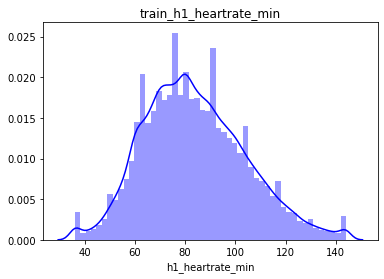

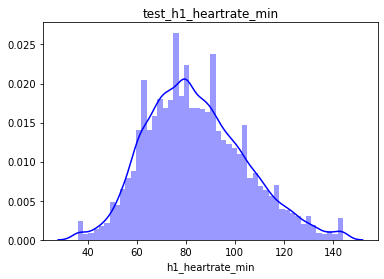

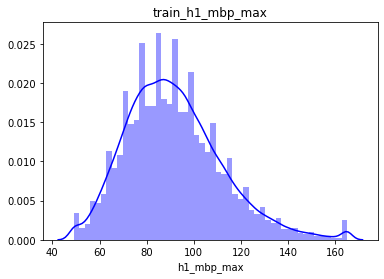

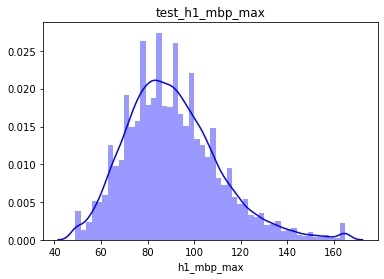

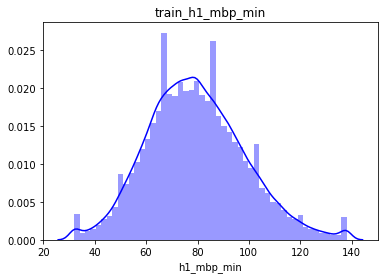

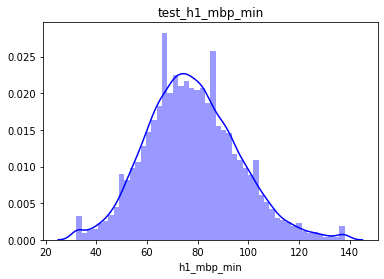

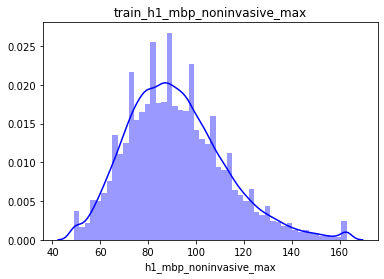

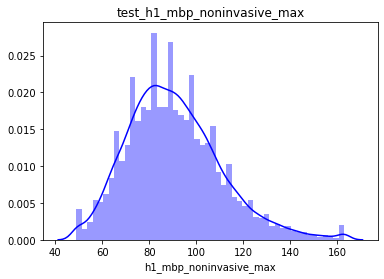

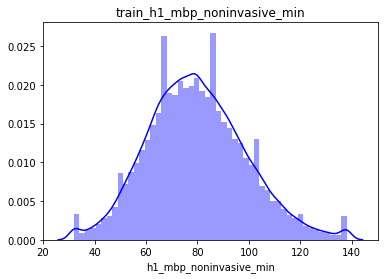

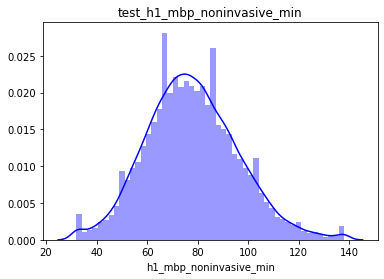

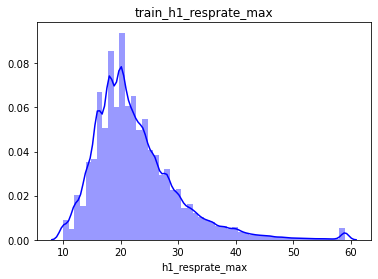

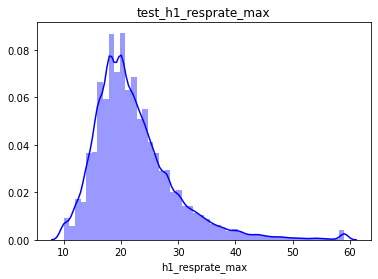

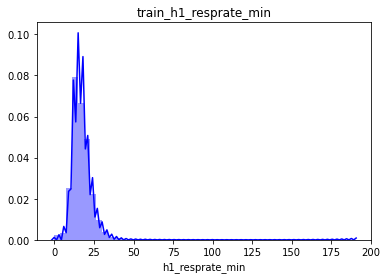

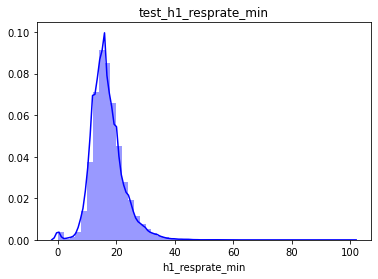

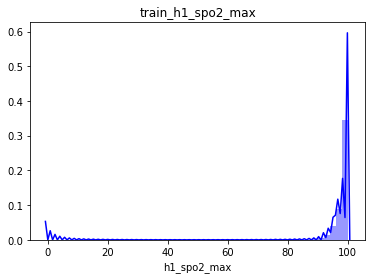

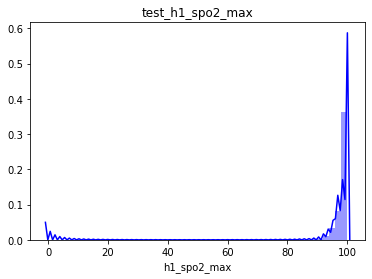

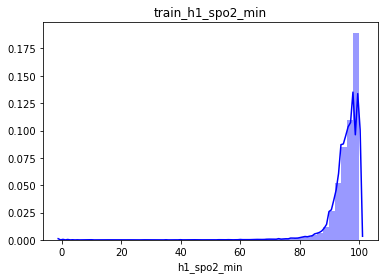

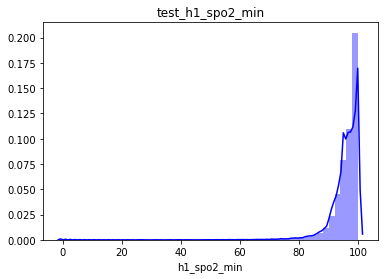

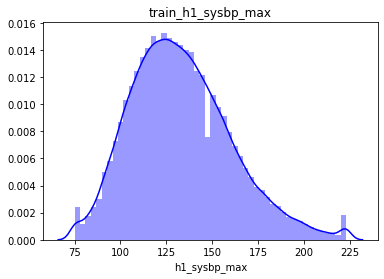

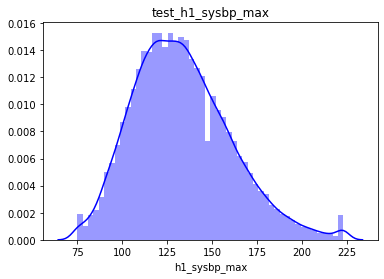

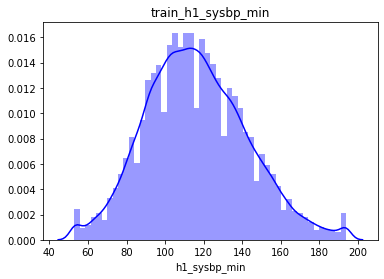

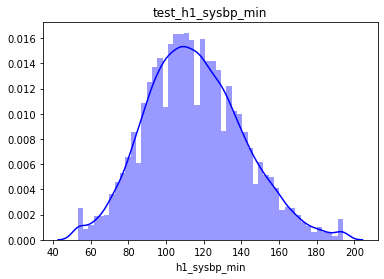

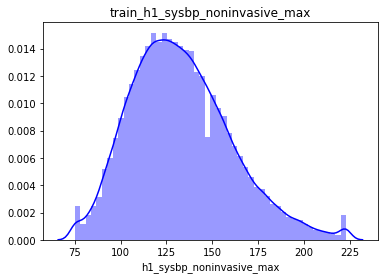

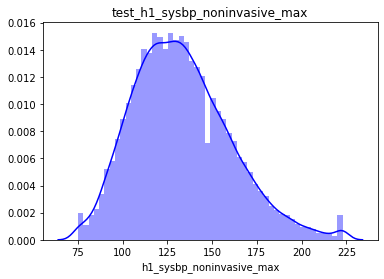

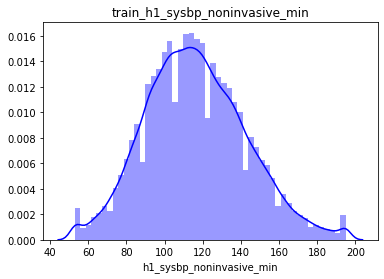

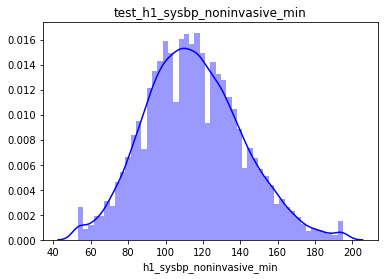

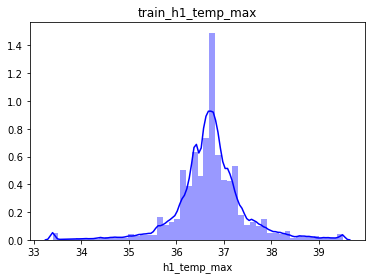

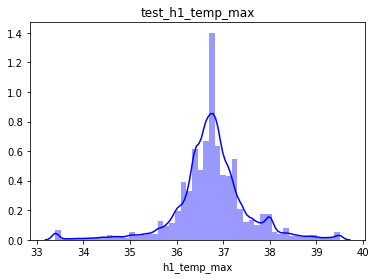

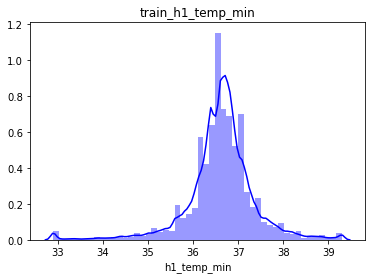

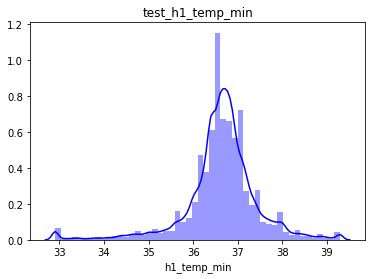

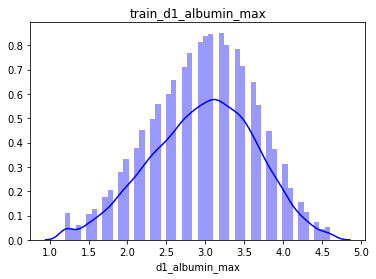

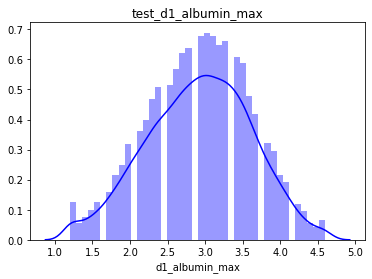

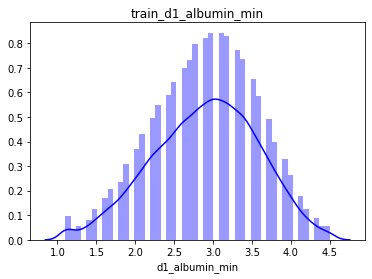

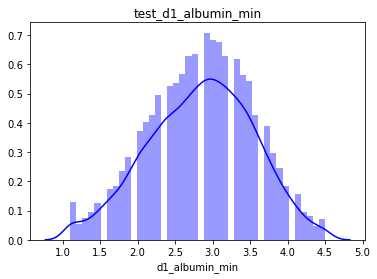

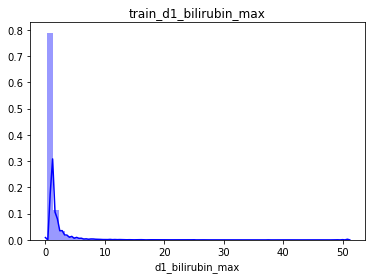

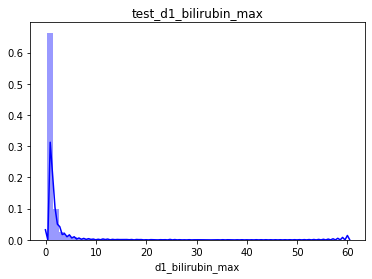

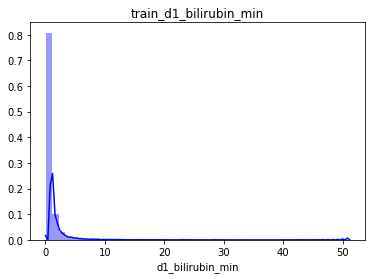

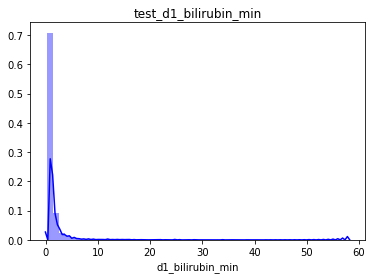

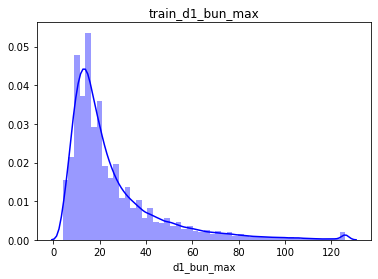

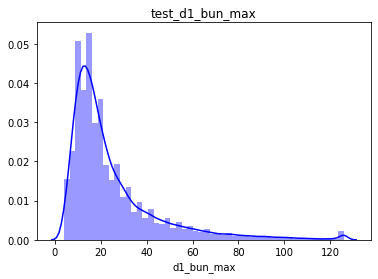

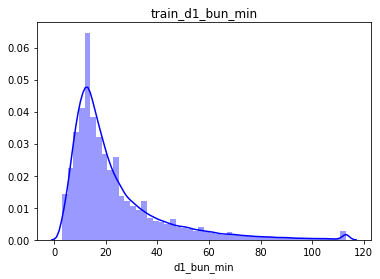

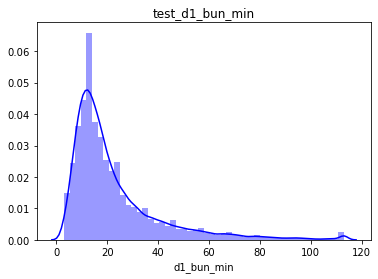

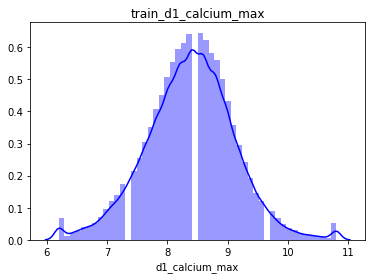

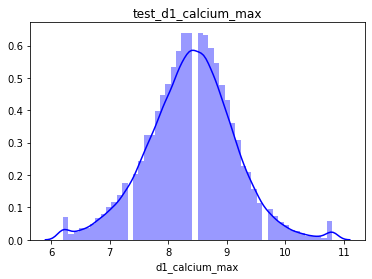

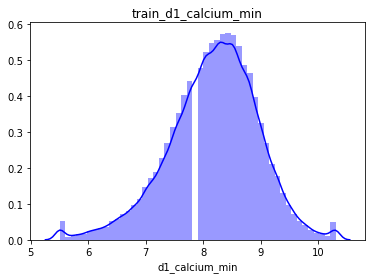

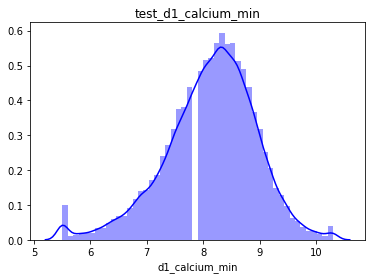

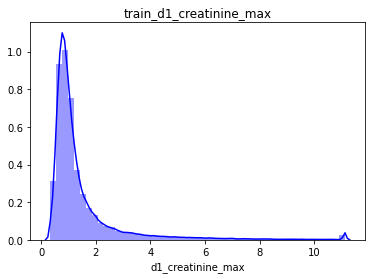

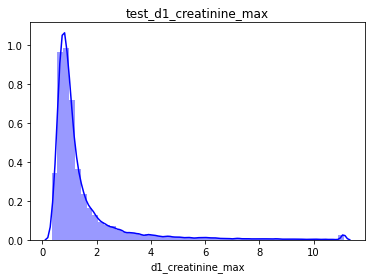

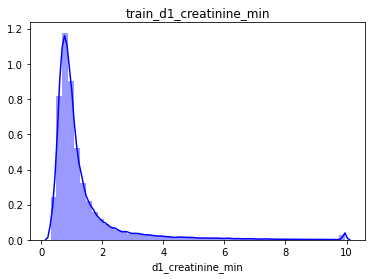

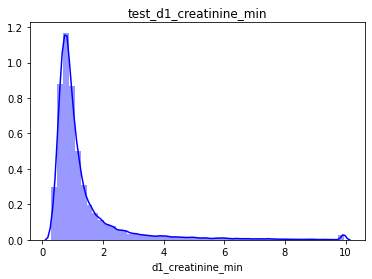

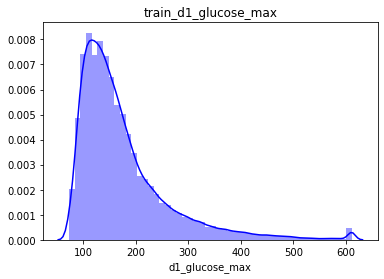

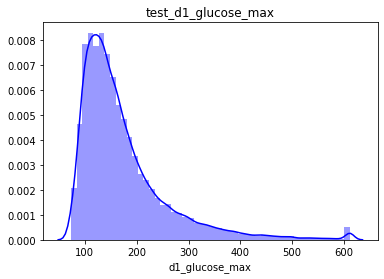

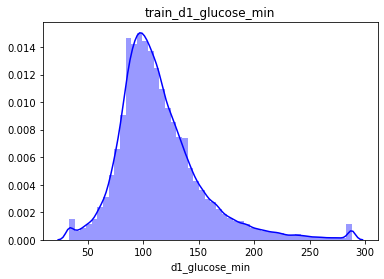

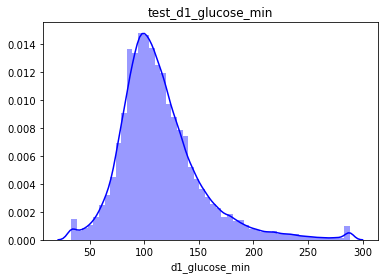

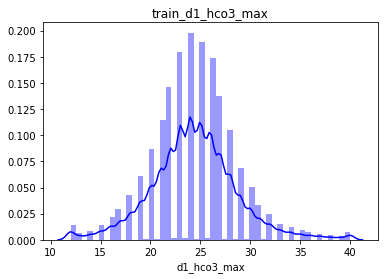

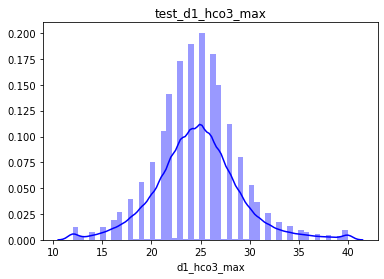

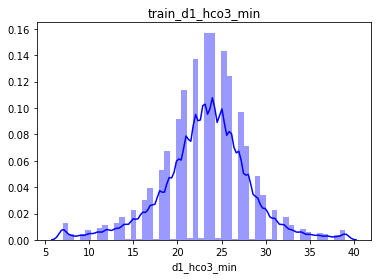

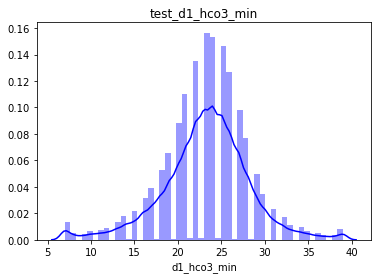

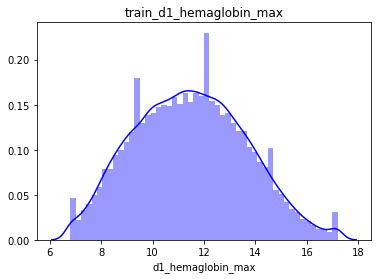

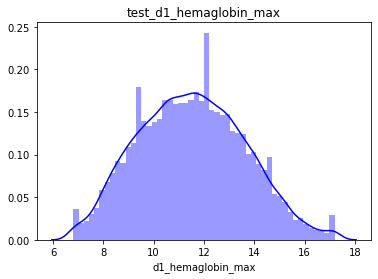

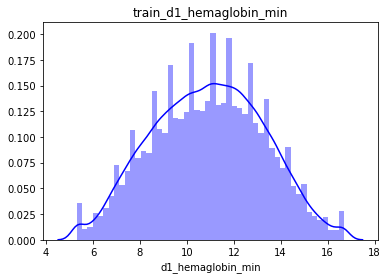

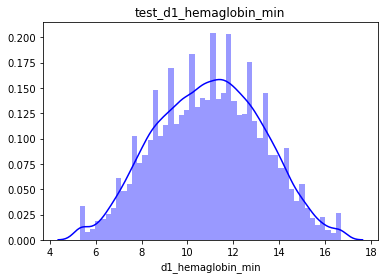

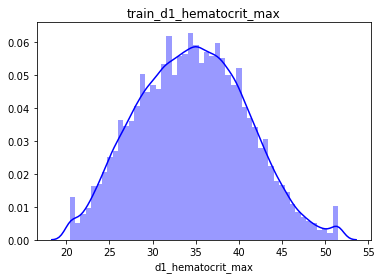

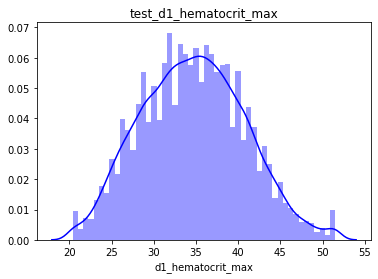

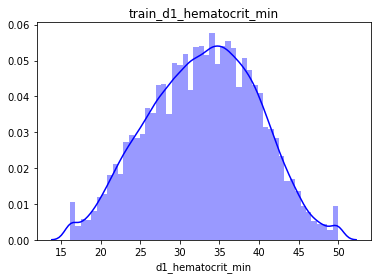

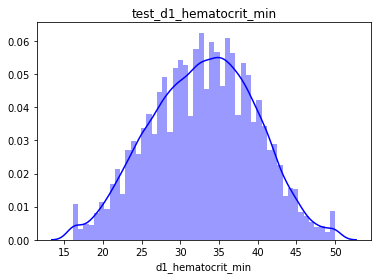

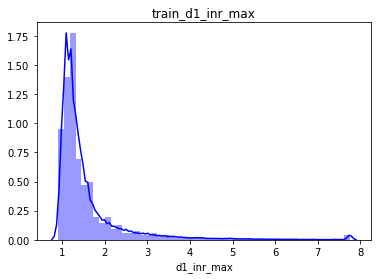

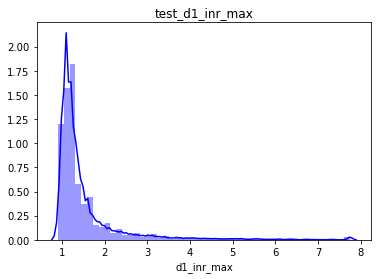

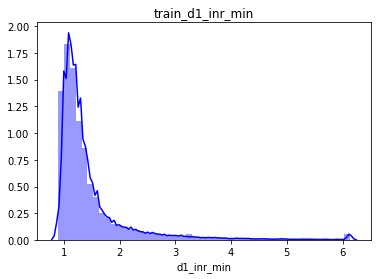

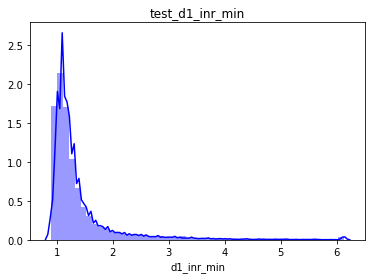

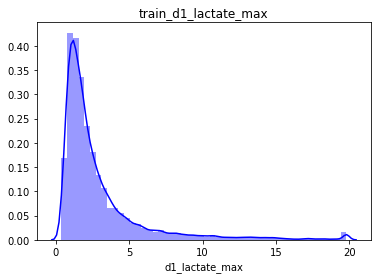

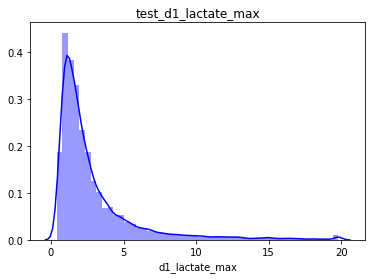

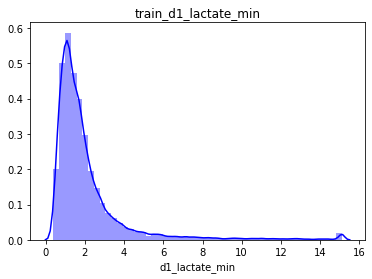

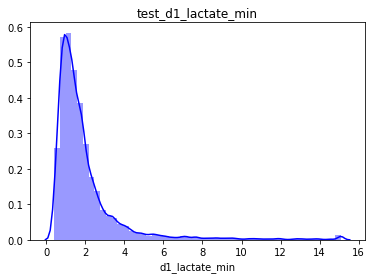

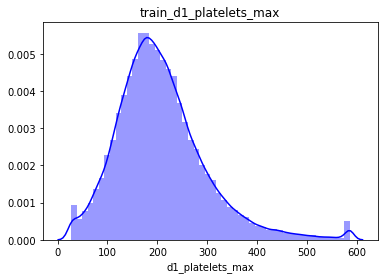

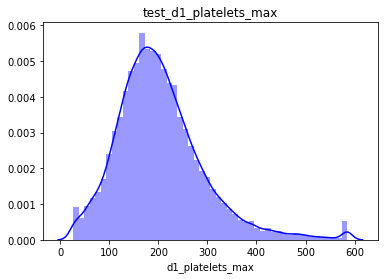

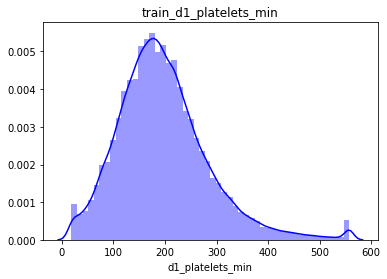

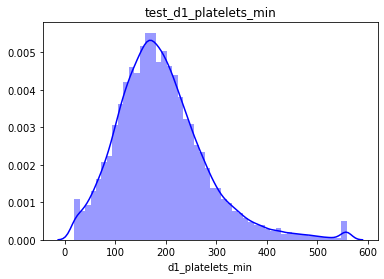

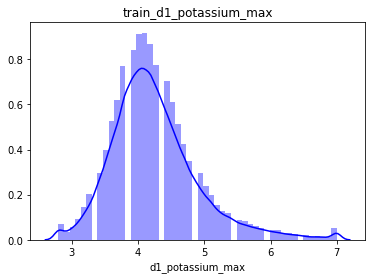

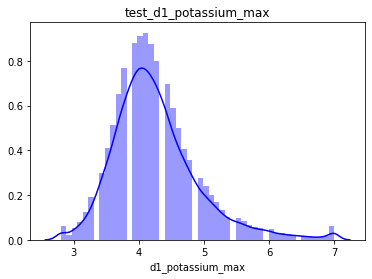

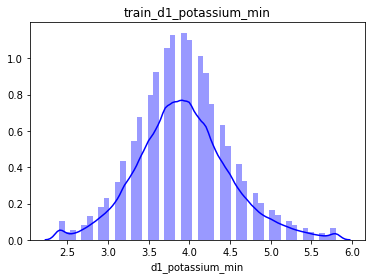

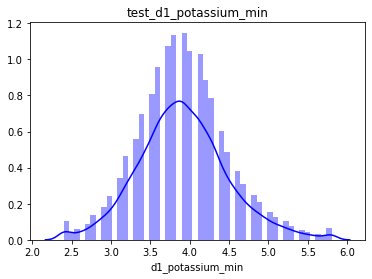

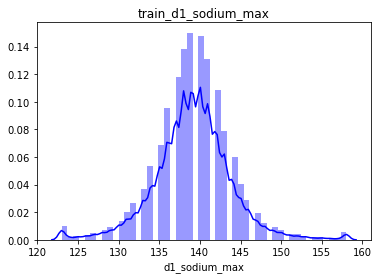

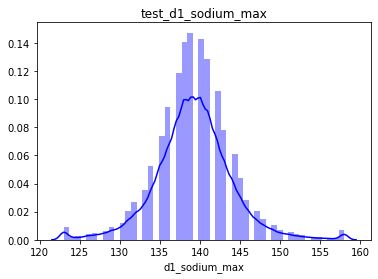

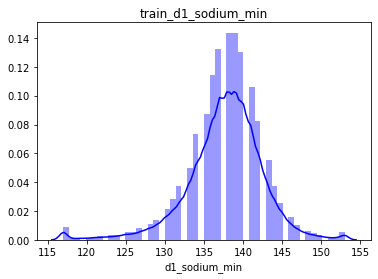

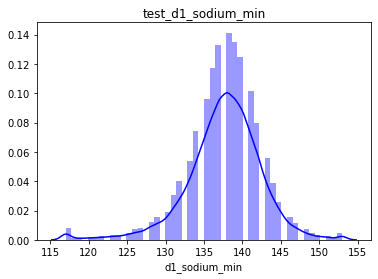

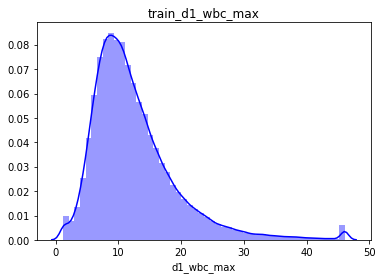

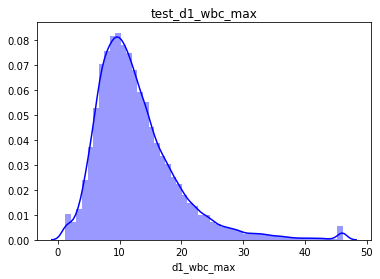

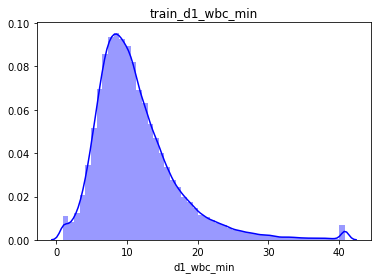

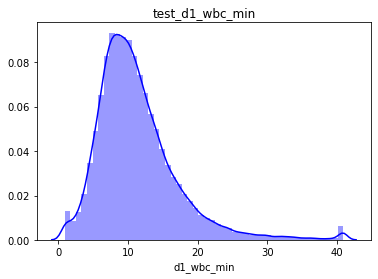

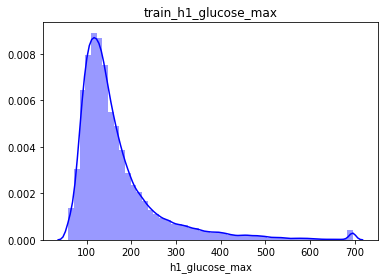

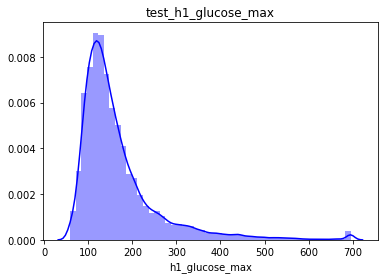

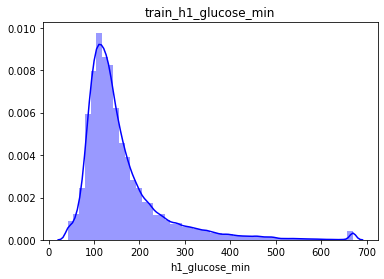

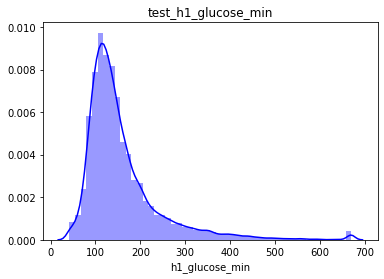

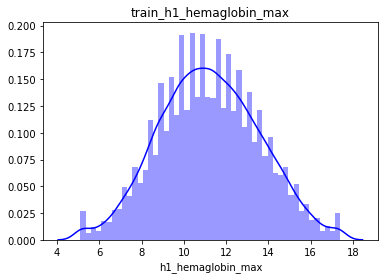

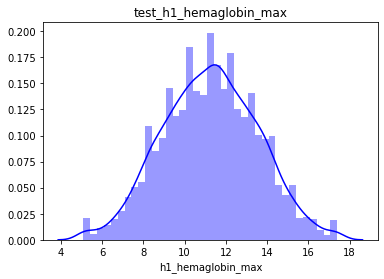

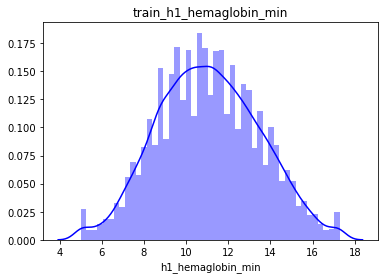

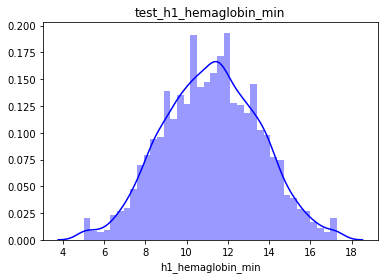

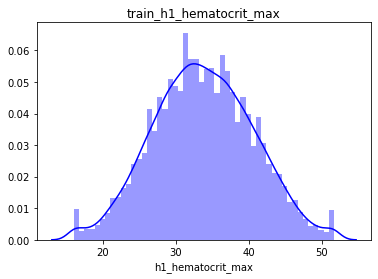

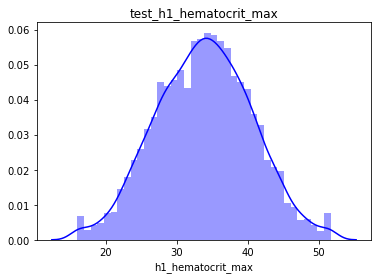

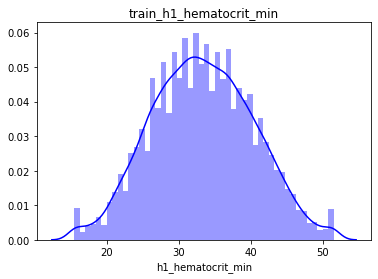

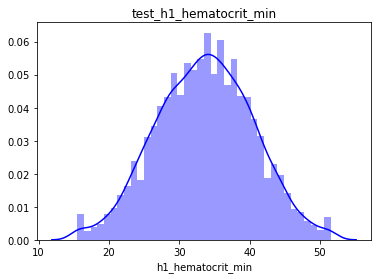

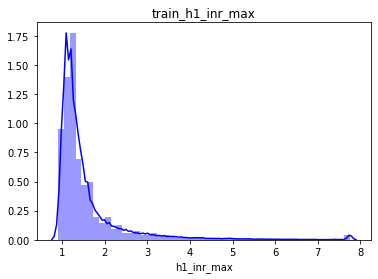

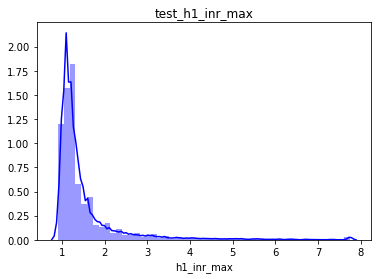

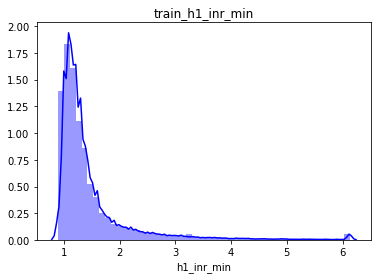

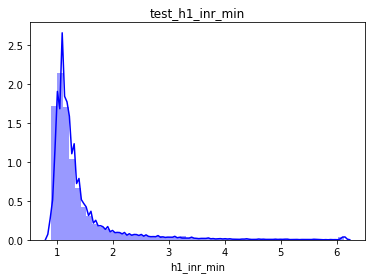

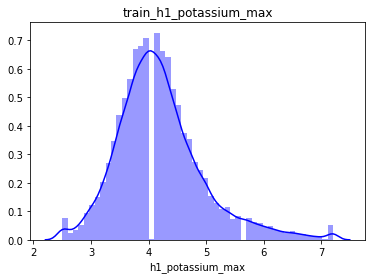

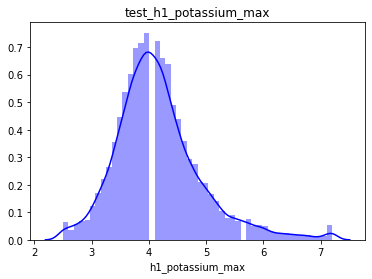

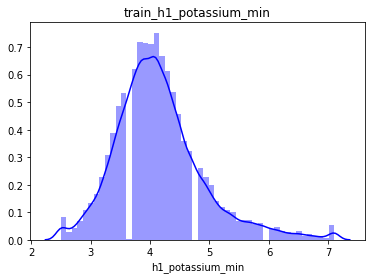

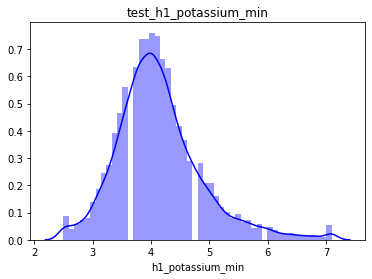

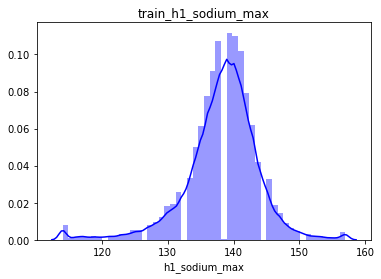

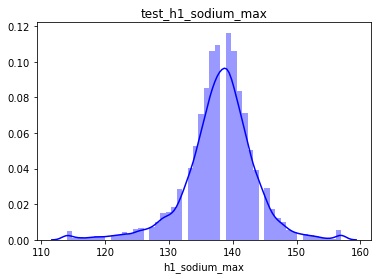

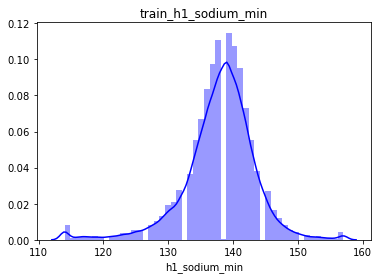

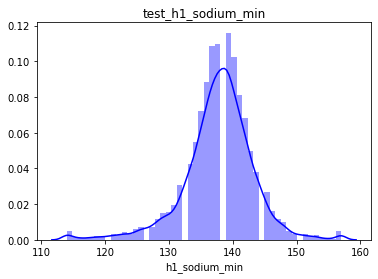

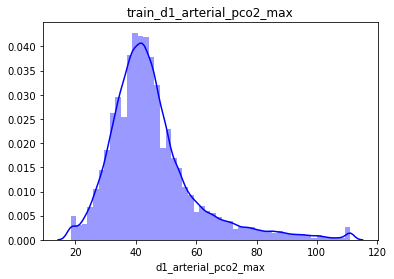

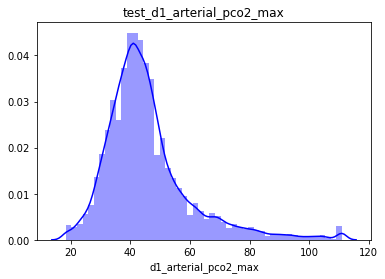

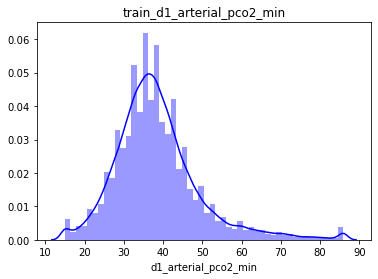

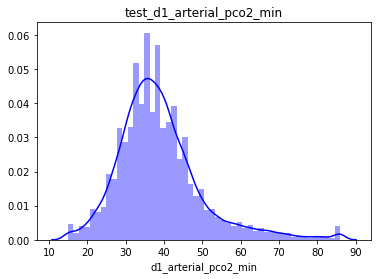

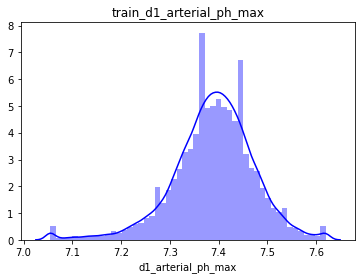

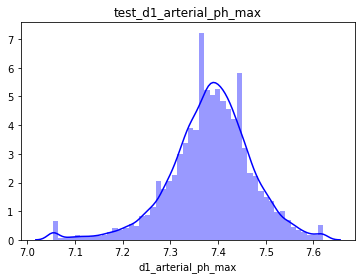

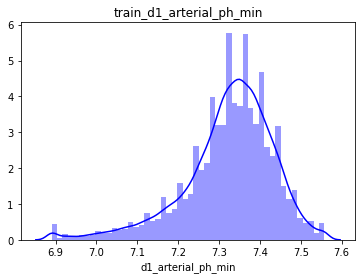

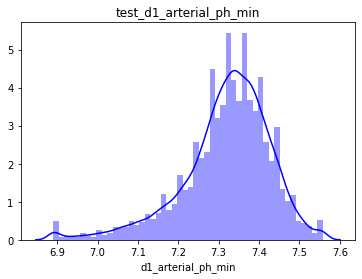

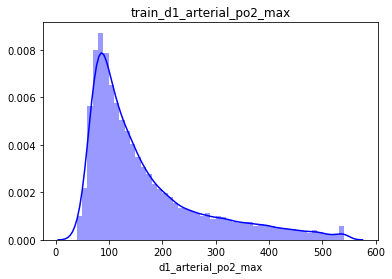

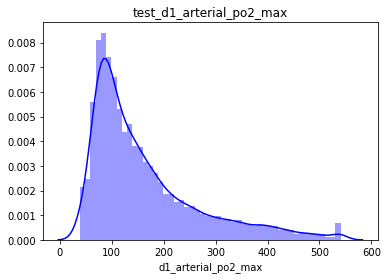

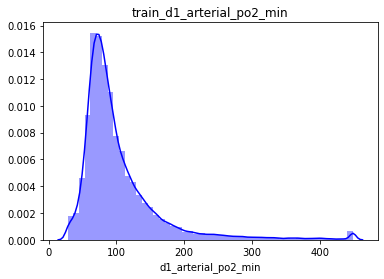

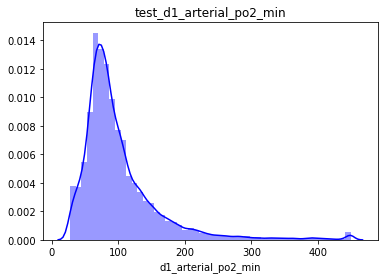

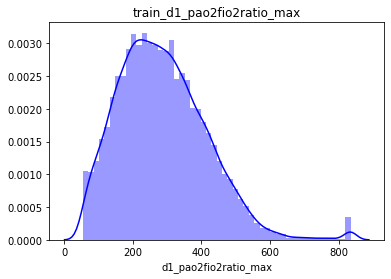

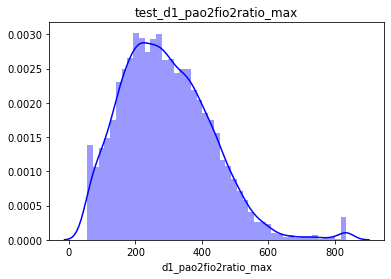

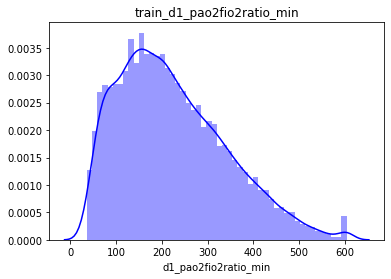

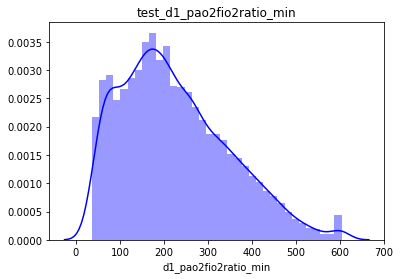

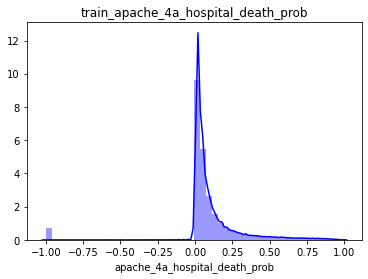

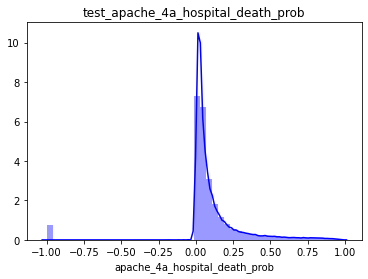

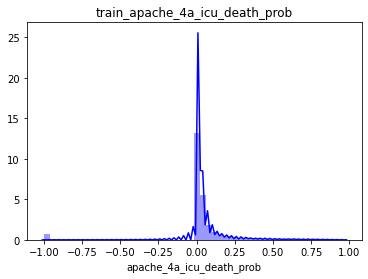

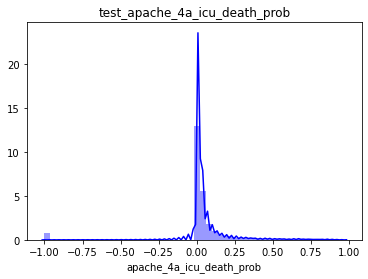

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


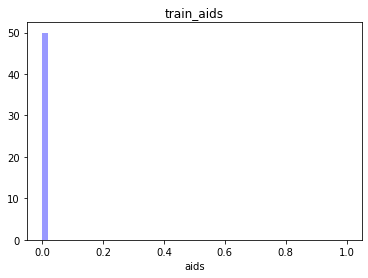

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


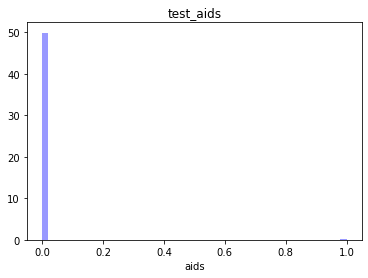

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


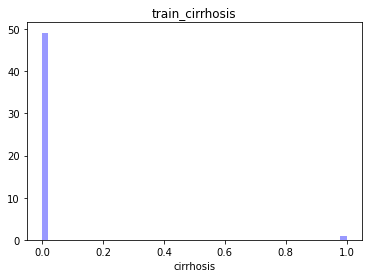

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


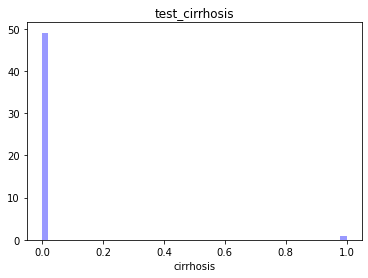

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


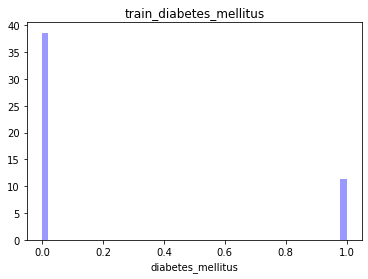

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


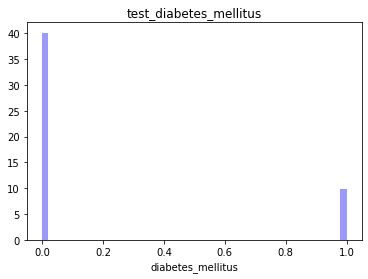

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


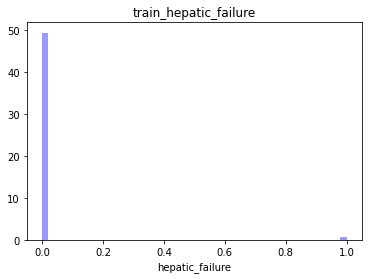

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


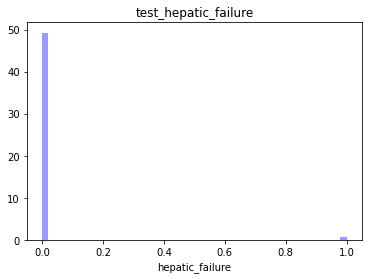

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


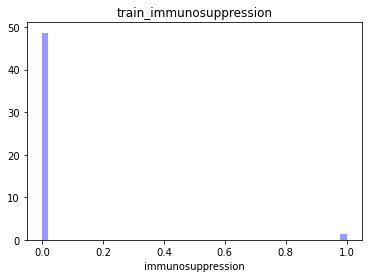

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


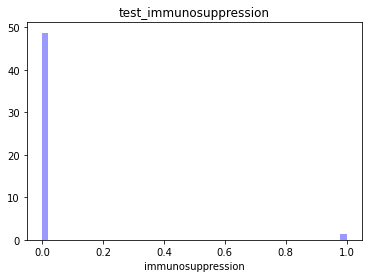

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


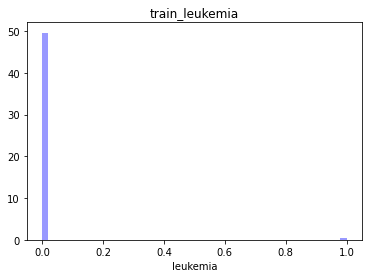

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


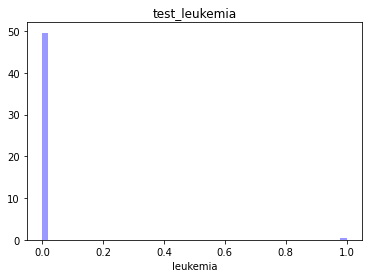

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


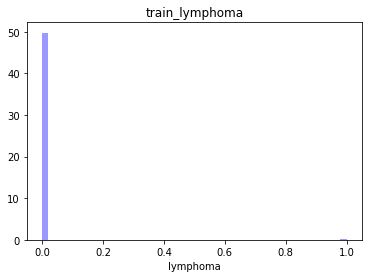

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


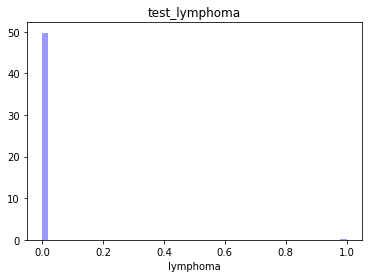

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


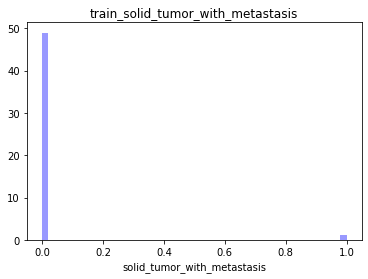

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


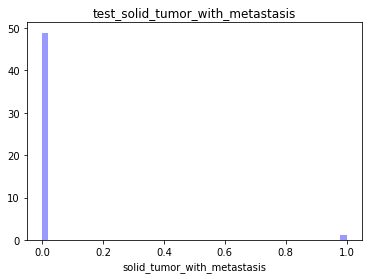

In [210]:
for col1, col2 in zip(train_col_list, test_col_list):
    plot_numeric(col1, col2)

In [211]:
## from the pattern we discover that readmission_status, aids, cirrhosis in both train1 and test1 data are all 0
## therefore, the other value should be the NA, then we should drop them from the whole dataset
## also we drop the hospital id becasue the id wont't help
combined_df2 = combined_df1.drop(columns=['readmission_status','aids','cirrhosis','hospital_id'],axis=1)

## update train and test dataset
train2 = copy.copy(combined_df2[:len(train)])
test2 = copy.copy(combined_df2[len(train):])

print(train2.shape)
print(test2.shape)

(91713, 148)
(33426, 148)


In [212]:
combined_df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125139 entries, 0 to 39307
Data columns (total 152 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   hospital_id                    int64  
 1   hospital_death                 float64
 2   age                            float64
 3   bmi                            float64
 4   elective_surgery               int64  
 5   ethnicity                      object 
 6   gender                         object 
 7   height                         float64
 8   hospital_admit_source          object 
 9   icu_admit_source               object 
 10  icu_id                         int64  
 11  icu_stay_type                  object 
 12  icu_type                       object 
 13  pre_icu_los_days               float64
 14  readmission_status             int64  
 15  weight                         float64
 16  albumin_apache                 float64
 17  apache_2_diagnosis             float64
 18  apac

In [213]:
##  also update the number_train and number_test
number_train = train2.select_dtypes(include=numerics)
number_test = test2.select_dtypes(include=numerics)

In [214]:
## check NA in train
train2.isna().sum()

hospital_death                    4228
age                                  0
bmi                               3378
elective_surgery                     0
ethnicity                         1361
gender                              14
height                            1343
hospital_admit_source            21673
icu_admit_source                   123
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
weight                            2665
albumin_apache                   54119
apache_2_diagnosis                 995
apache_3j_diagnosis                421
apache_post_operative                0
arf_apache                           0
bilirubin_apache                 57731
bun_apache                       18430
creatinine_apache                18009
fio2_apache                      70336
gcs_eyes_apache                   1254
gcs_motor_apache                  1254
gcs_unable_apache        

In [215]:
## check NA in test
test2.isna().sum()

hospital_death                   33426
age                                  0
bmi                                900
elective_surgery                     0
ethnicity                          139
gender                               8
height                             620
hospital_admit_source            10176
icu_admit_source                    98
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
weight                             638
albumin_apache                   20848
apache_2_diagnosis                 621
apache_3j_diagnosis                381
apache_post_operative                0
arf_apache                           0
bilirubin_apache                 21391
bun_apache                        5824
creatinine_apache                 5725
fio2_apache                      25169
gcs_eyes_apache                    854
gcs_motor_apache                   854
gcs_unable_apache        

In [73]:
train2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91713 entries, 0 to 91712
Data columns (total 148 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   hospital_death                 float64
 1   age                            float64
 2   bmi                            float64
 3   elective_surgery               int64  
 4   ethnicity                      object 
 5   gender                         object 
 6   height                         float64
 7   hospital_admit_source          object 
 8   icu_admit_source               object 
 9   icu_id                         int64  
 10  icu_stay_type                  object 
 11  icu_type                       object 
 12  pre_icu_los_days               float64
 13  weight                         float64
 14  albumin_apache                 float64
 15  apache_2_diagnosis             float64
 16  apache_3j_diagnosis            float64
 17  apache_post_operative          int64  
 18  arf_a

### 1.3.2 Missing values among categorical variables

In [218]:
train3 = copy.copy(train2)
test3 = copy.copy(test2)
print(train3.shape)
print(test3.shape)

(91713, 148)
(33426, 148)


In [219]:
category_train = train3.select_dtypes(include=['object','category'])
category_test = test3.select_dtypes(include=['object','category'])

In [220]:
## check categorical columns in train 
for i in category_train.columns:
    print(str(i) + ":" + "\n" + str(category_train[i].unique()) + "\n")

ethnicity:
['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']

gender:
['M' 'F' nan]

hospital_admit_source:
['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']

icu_admit_source:
['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]

icu_stay_type:
['admit' 'readmit' 'transfer']

icu_type:
['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']

apache_3j_bodysystem:
['Sepsis' 'Respiratory' 'Metabolic' 'Cardiovascular' 'Trauma'
 'Neurological' 'Gastrointestinal' 'Genitourinary' nan 'Hematological'
 'Musculoskeletal/Skin' 'Gynecological']

apache_2_bodysystem:
['Cardiovascular' 'Respiratory' 'Metabolic' 'Trauma' 'Neurologic'
 'Gastrointestinal' 'Renal/Genitourinary' nan 'Undefined diagnoses'
 'Haematologi

In [221]:
## check categorical columns in test
for i in category_test.columns:
    print(str(i) + ":" + "\n" + str(category_test[i].unique()) + "\n")

ethnicity:
['Caucasian' 'African American' 'Hispanic' 'Other/Unknown' 'Asian' nan
 'Native American']

gender:
['F' 'M' nan]

hospital_admit_source:
[nan 'Direct Admit' 'Emergency Department' 'Operating Room' 'Floor'
 'Recovery Room' 'Chest Pain Center' 'Other Hospital' 'Acute Care/Floor'
 'Step-Down Unit (SDU)' 'Other ICU' 'ICU to SDU' 'PACU' 'ICU' 'Other']

icu_admit_source:
[nan 'Operating Room / Recovery' 'Accident & Emergency' 'Floor'
 'Other Hospital' 'Other ICU']

icu_stay_type:
['admit' 'readmit' 'transfer']

icu_type:
['Med-Surg ICU' 'MICU' 'Neuro ICU' 'SICU' 'Cardiac ICU' 'CSICU'
 'CCU-CTICU' 'CTICU']

apache_3j_bodysystem:
['Sepsis' 'Cardiovascular' 'Respiratory' 'Metabolic' 'Neurological'
 'Hematological' 'Trauma' 'Genitourinary' 'Gastrointestinal'
 'Musculoskeletal/Skin' nan 'Gynecological']

apache_2_bodysystem:
['Cardiovascular' 'Respiratory' 'Metabolic' 'Neurologic' 'Haematologic'
 'Trauma' 'Renal/Genitourinary' 'Undefined diagnoses' 'Gastrointestinal'
 'Undefined Diagn

In [222]:
## visualize the pattern of each variables in train and test
def plot_category(column):
        sns.catplot(x=column, data = train3, kind = 'count', alpha=0.7,aspect=3.5)
        plt.title("train_" + str(column))

        sns.catplot(x=column,data = test3, kind = 'count', alpha=0.7,aspect=3.5)
        plt.title("test_" + str(column))


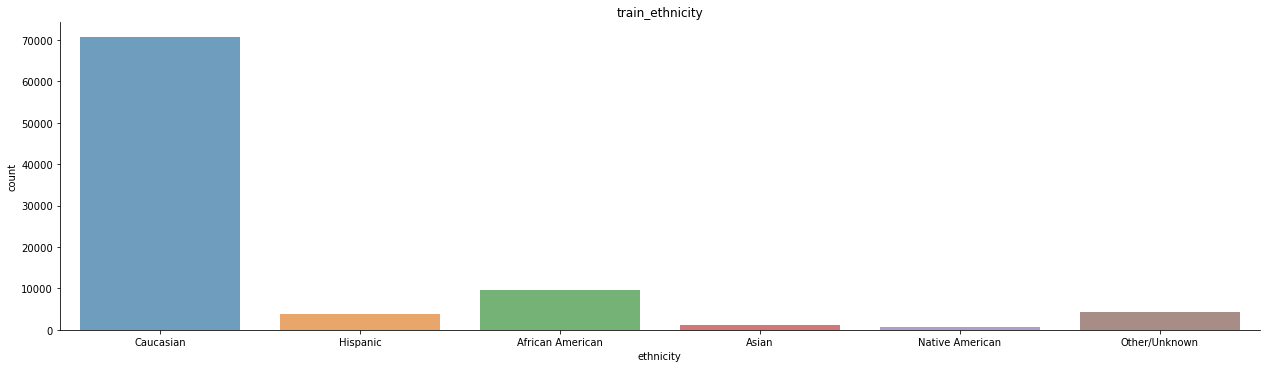

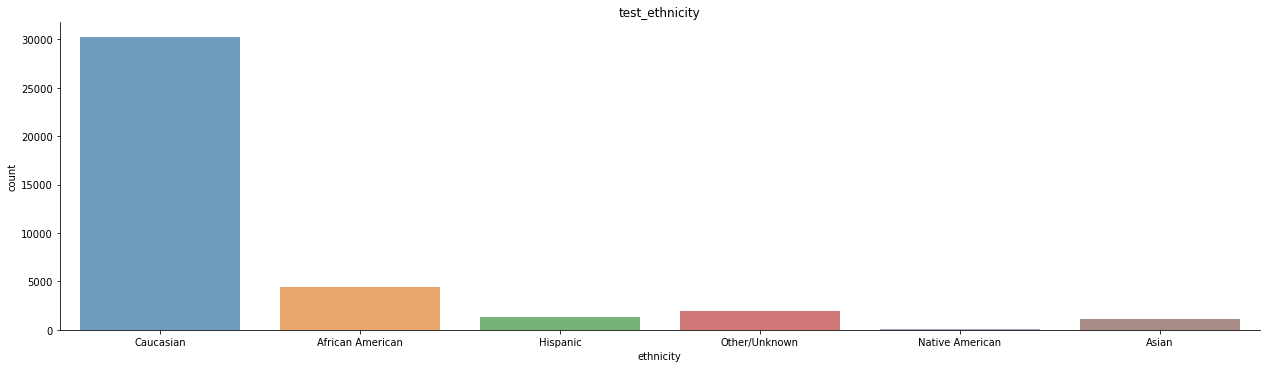

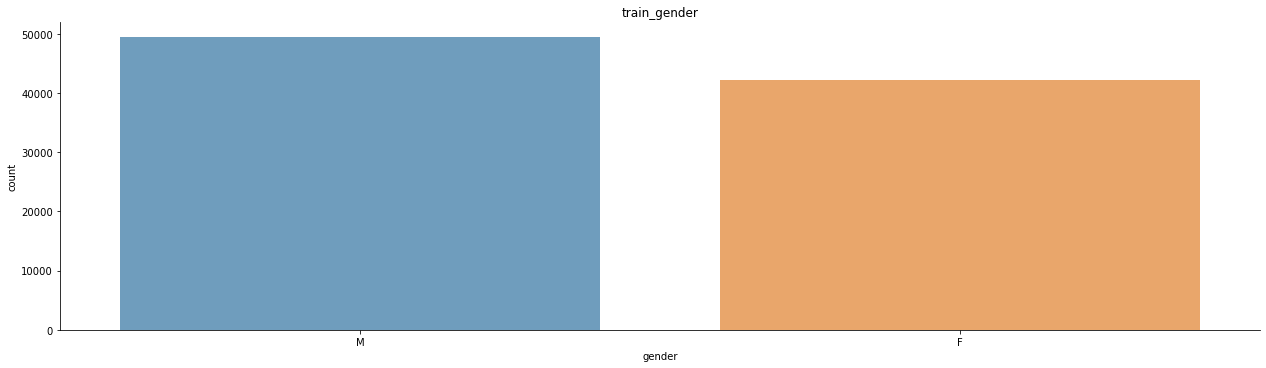

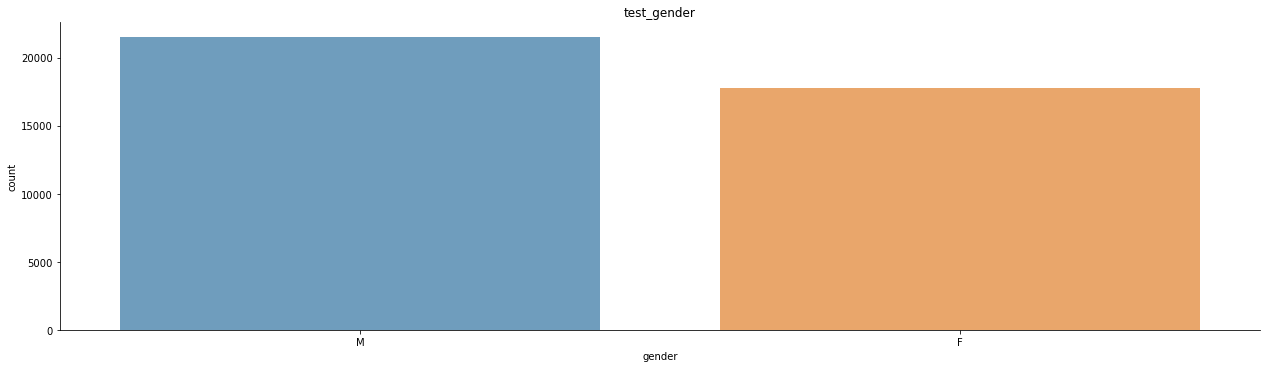

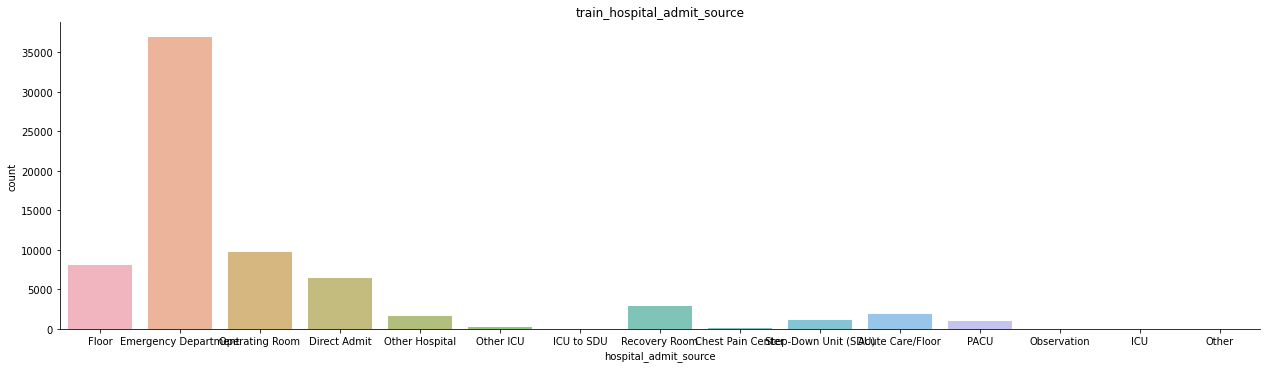

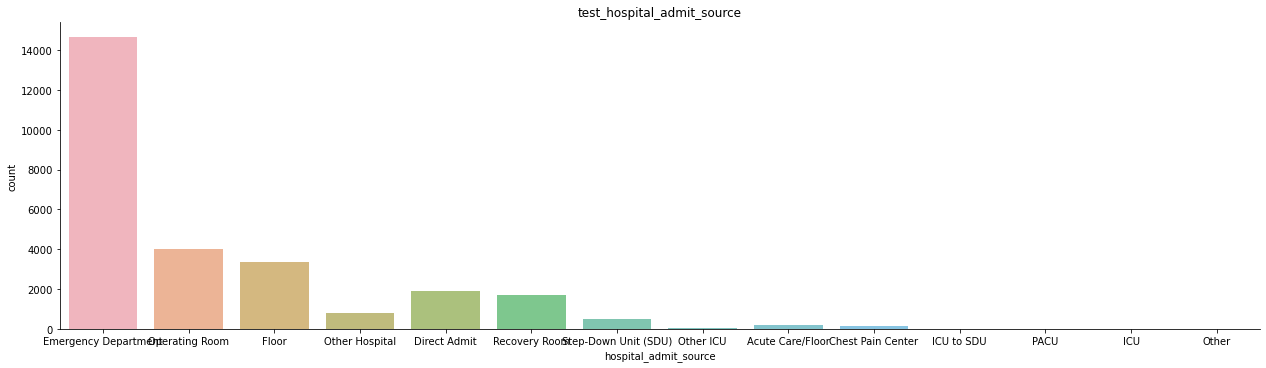

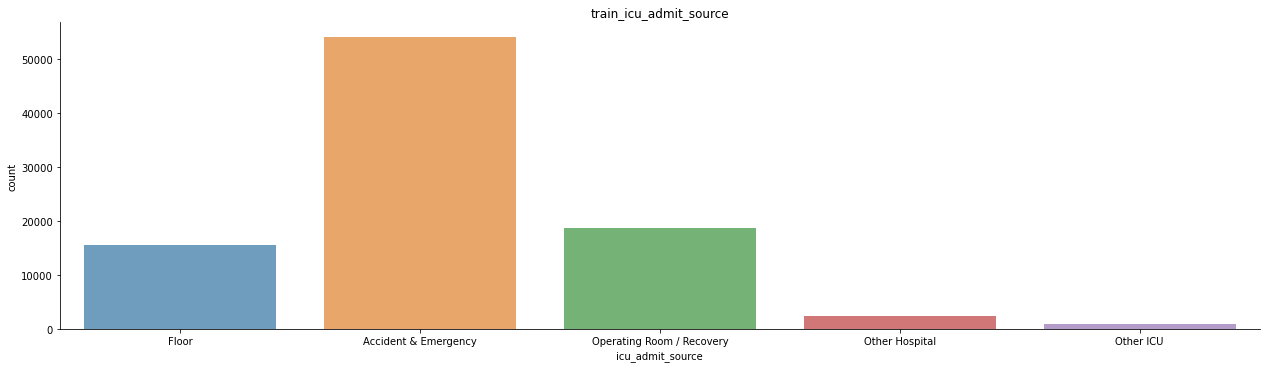

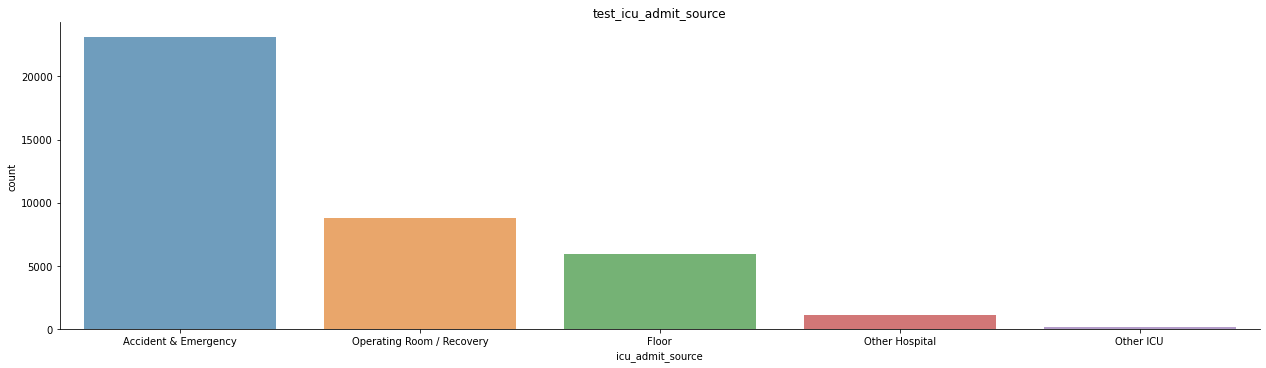

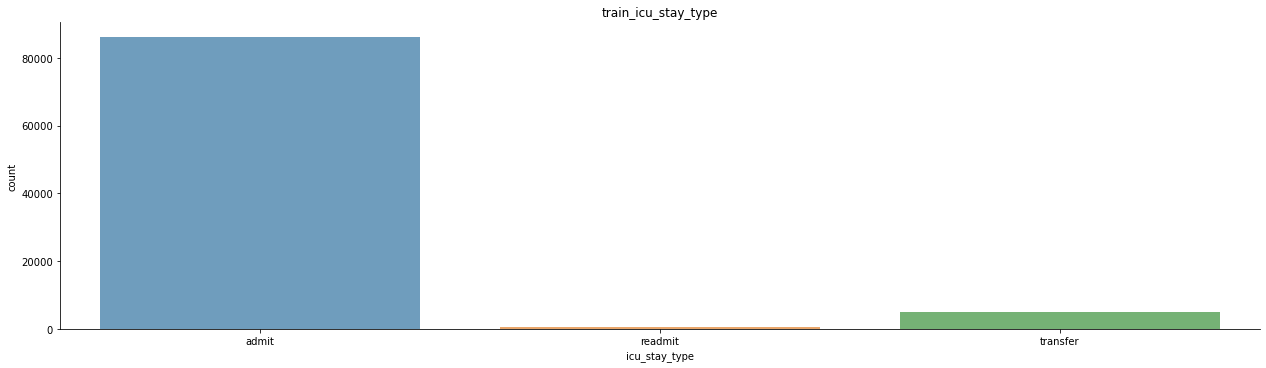

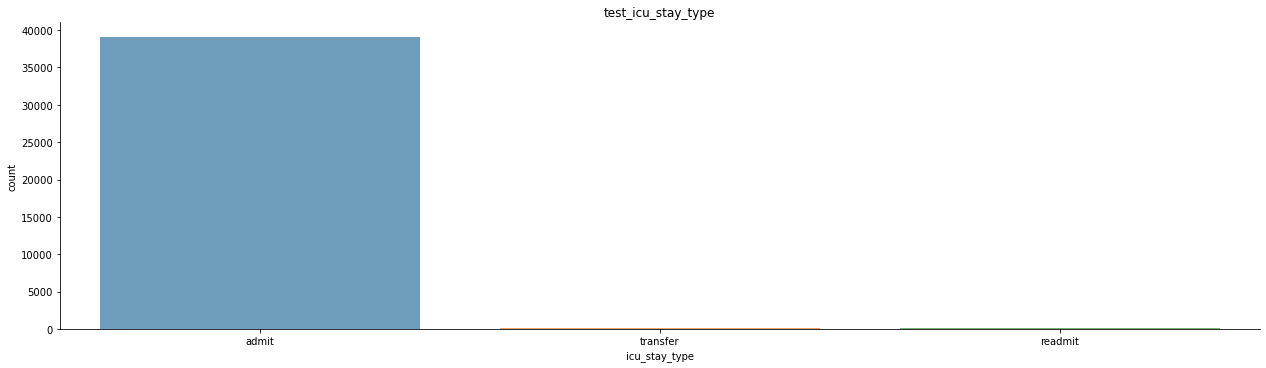

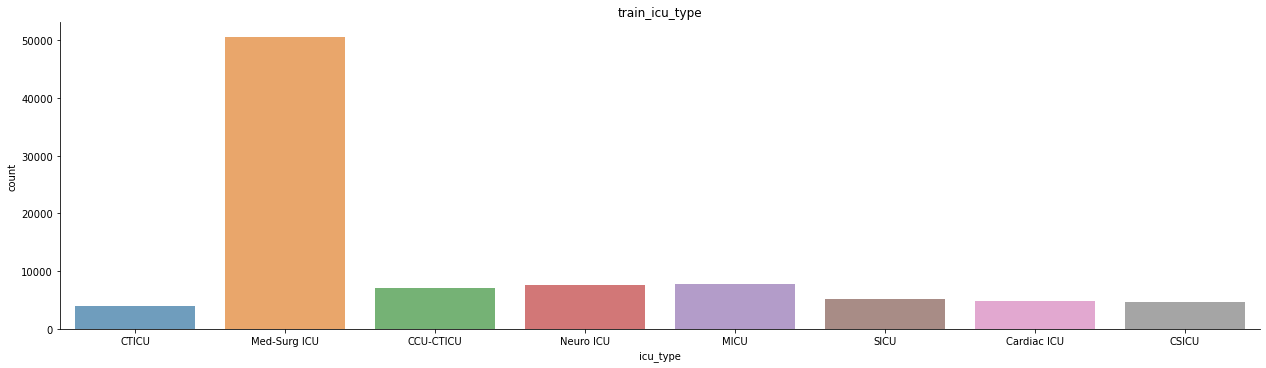

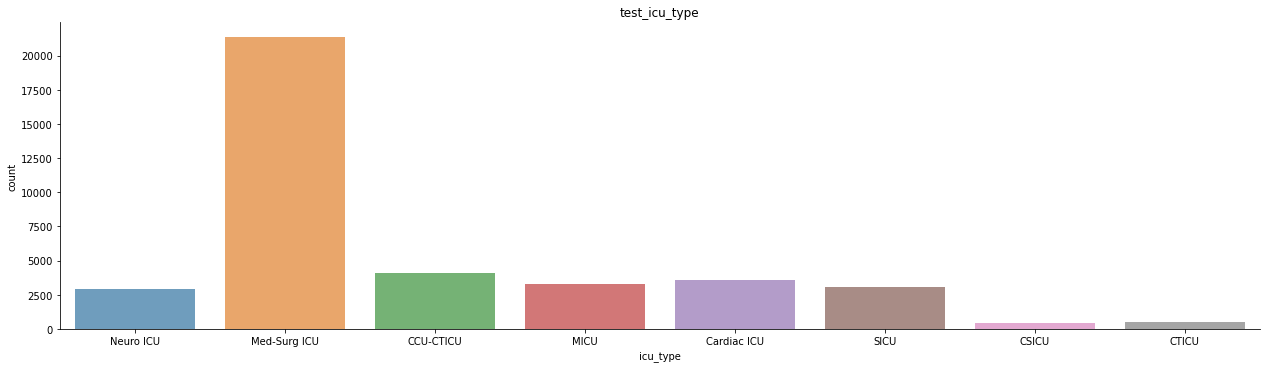

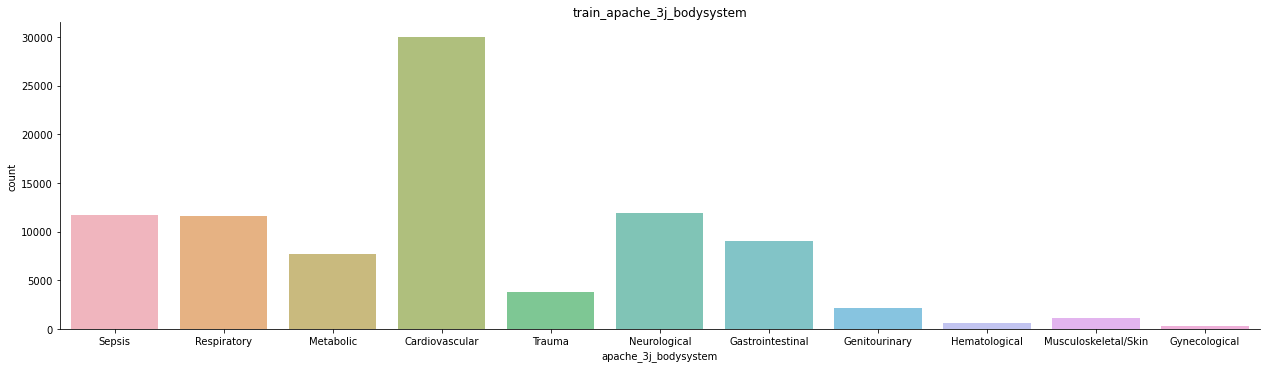

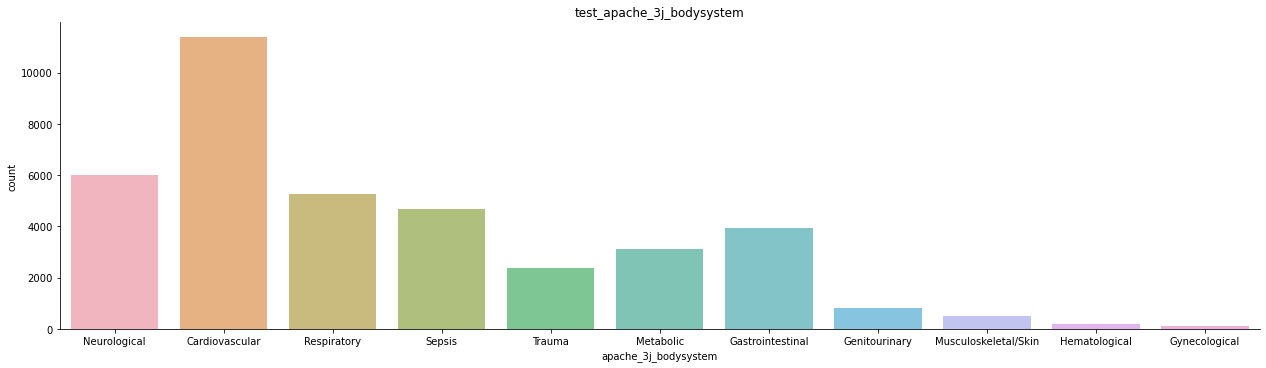

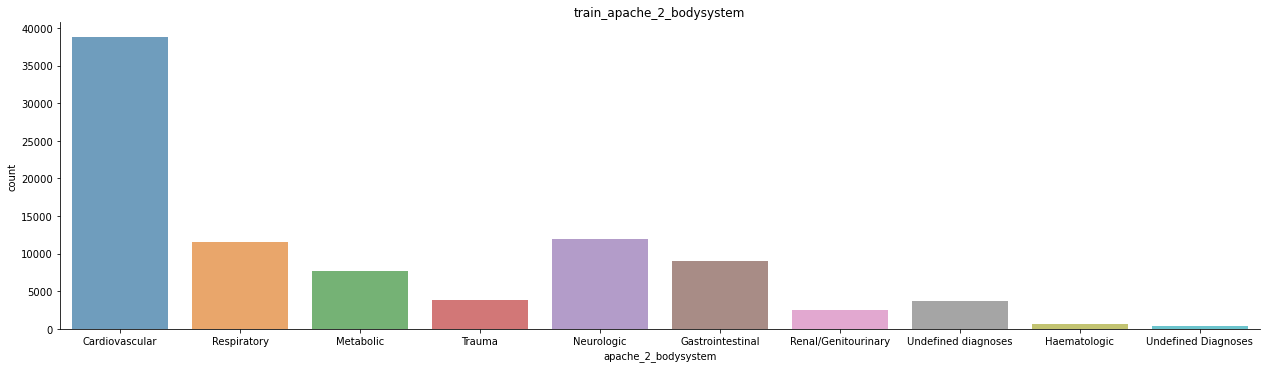

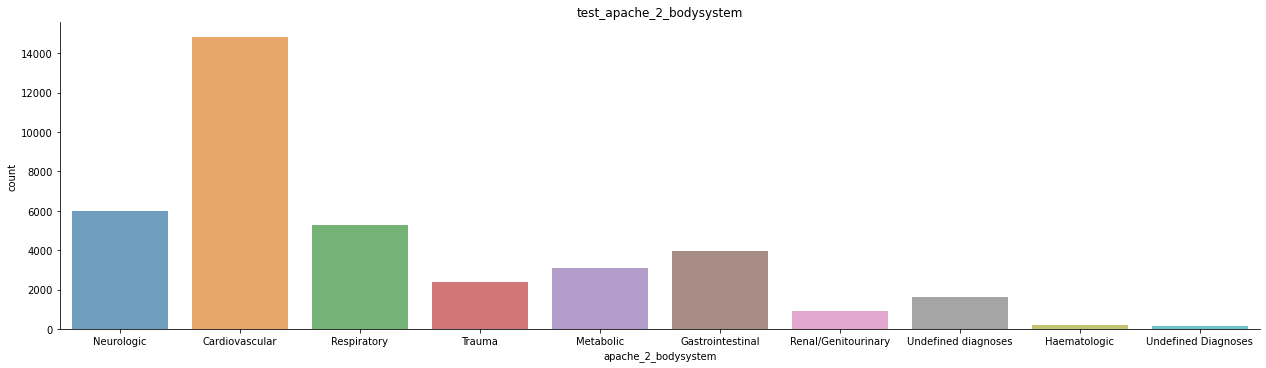

In [79]:
for col in category_train:
    plot_category(col)

## we could find that hospital_admit_source has different distribution in train and test data

In [223]:
# check NA in train
print("Train:" + "\n")
for i in category_train.columns:
    print(str(i) + ":" + "\n" + str(category_train[i].isna().sum()) + "\n")

# check NA in test
print("Test:" + "\n")
for i in category_test.columns:
    print(str(i) + ":" + "\n" + str(category_test[i].isna().sum()) + "\n")

Train:

ethnicity:
1361

gender:
14

hospital_admit_source:
21673

icu_admit_source:
123

icu_stay_type:
0

icu_type:
0

apache_3j_bodysystem:
995

apache_2_bodysystem:
995

Test:

ethnicity:
139

gender:
8

hospital_admit_source:
10176

icu_admit_source:
98

icu_stay_type:
0

icu_type:
0

apache_3j_bodysystem:
621

apache_2_bodysystem:
621



## 1.4 Impute missig values

### 1.4.1 Categorical varibles 

In [224]:
category_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91713 entries, 0 to 4385
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ethnicity              90352 non-null  object
 1   gender                 91699 non-null  object
 2   hospital_admit_source  70040 non-null  object
 3   icu_admit_source       91590 non-null  object
 4   icu_stay_type          91713 non-null  object
 5   icu_type               91713 non-null  object
 6   apache_3j_bodysystem   90718 non-null  object
 7   apache_2_bodysystem    90718 non-null  object
dtypes: object(8)
memory usage: 6.3+ MB


In [225]:
## impute the categorical missing values first
## calcute the percentage of NA of each column
for i in category_train.columns:
    print(train3[i].isna().sum()/len(train3))

0.014839771897113822
0.00015265011503276527
0.2363132816503658
0.0013411402963592947
0.0
0.0
0.01084906174697153
0.01084906174697153


In [226]:
## for gender, icu_admit_source, icu_stay_type, icu_type we drop the NAs, because the number is small
category_train=category_train.dropna(subset=['gender', 'icu_admit_source','icu_stay_type', 'icu_type'])
category_test=category_test.dropna(subset=['gender', 'icu_admit_source','icu_stay_type', 'icu_type'])

for i in category_train.columns:
    print(category_train[i].isna().sum()/len(category_train))

train4=train3.dropna(subset=['gender', 'icu_admit_source','icu_stay_type', 'icu_type'])
for i in category_train.columns:
    print(train4[i].isna().sum()/len(train4))

0.014720013977461343
0.0
0.23532366558923737
0.0
0.0
0.0
0.010646894382807722
0.010646894382807722
0.014720013977461343
0.0
0.23532366558923737
0.0
0.0
0.0
0.010646894382807722
0.010646894382807722


In [227]:
## do the same thing for test dataset
test4=test3.dropna(subset=['gender', 'icu_admit_source','icu_stay_type', 'icu_type'])
for i in category_test.columns:
    print(test4[i].isna().sum()/len(test4))

0.004141656662665066
0.0
0.3024909963985594
0.0
0.0
0.0
0.01725690276110444
0.01725690276110444


In [228]:
## for apache_3j_bodysystem and apache_2_bodysystem, fill the NAs with 'missing' to represent
cols_to_fill =['apache_3j_bodysystem','apache_2_bodysystem']
for i in cols_to_fill:
    category_train[i]=category_train[i].fillna('missing')
    category_test[i]=category_test[i].fillna('missing')
    train4[i]=train4[i].fillna('missing')
    test4[i]=test4[i].fillna('missing')

/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/weiyizhong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [229]:
## check the result
category_train['apache_3j_bodysystem'].value_counts(), category_train['apache_2_bodysystem'].value_counts()

(Cardiovascular          30123
 Neurological            12072
 Respiratory             11780
 Sepsis                  11579
 Gastrointestinal         8962
 Metabolic                7905
 Trauma                   3858
 Genitourinary            2202
 Musculoskeletal/Skin     1170
 missing                   975
 Hematological             627
 Gynecological             323
 Name: apache_3j_bodysystem, dtype: int64,
 Cardiovascular         38644
 Neurologic             12072
 Respiratory            11780
 Gastrointestinal        8962
 Metabolic               7905
 Undefined diagnoses     3903
 Trauma                  3858
 Renal/Genitourinary     2500
 missing                  975
 Haematologic             627
 Undefined Diagnoses      350
 Name: apache_2_bodysystem, dtype: int64)

In [230]:
## check NA percentage again
## there are ethnicity and hospital_admit_source left
for i in category_train.columns:
    print(str(i) + ': ' + str(train4[i].isna().sum()/len(train4)))


ethnicity: 0.014720013977461343
gender: 0.0
hospital_admit_source: 0.23532366558923737
icu_admit_source: 0.0
icu_stay_type: 0.0
icu_type: 0.0
apache_3j_bodysystem: 0.0
apache_2_bodysystem: 0.0


In [231]:
## drop NAs in ethinicity
category_train=category_train.dropna(subset=['ethnicity'], how='all')
category_test=category_test.dropna(subset=['ethnicity'], how='all')
train4=train4.dropna(subset=['ethnicity'], how='all')
test4=test4.dropna(subset=['ethnicity'], how='all')

for i in category_train.columns:
       print(str(i) + ': ' + str(train4[i].isna().sum()/len(train4)))

ethnicity: 0.0
gender: 0.0
hospital_admit_source: 0.2376867491244403
icu_admit_source: 0.0
icu_stay_type: 0.0
icu_type: 0.0
apache_3j_bodysystem: 0.0
apache_2_bodysystem: 0.0


In [232]:
## for hospital_admit_source， fill with the the first type bacause the frequency is relatively high
val_to_replace=train4['hospital_admit_source'].value_counts().index[0]
category_train['hospital_admit_source']=category_train['hospital_admit_source'].fillna(val_to_replace)
category_test['hospital_a dmit_source']=category_test['hospital_admit_source'].fillna(val_to_replace)
train4['hospital_admit_source']=train4['hospital_admit_source'].fillna(val_to_replace)
test4['hospital_admit_source']=test4['hospital_admit_source'].fillna(val_to_replace)


In [233]:
## check final results
for i in category_train.columns:
       print(str(i) + ': ' + str(train4[i].isna().sum()/len(train4)))

ethnicity: 0.0
gender: 0.0
hospital_admit_source: 0.0
icu_admit_source: 0.0
icu_stay_type: 0.0
icu_type: 0.0
apache_3j_bodysystem: 0.0
apache_2_bodysystem: 0.0


#### 1.4.1.1 Convert categorical variables into numeric varibles

In [234]:
le = preprocessing.LabelEncoder()

for col in category_train.columns:
    train4[col]=le.fit_transform(train4[col])

In [235]:
## check result
train4.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90228 entries, 0 to 4385
Data columns (total 148 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   hospital_death                 float64
 1   age                            float64
 2   bmi                            float64
 3   elective_surgery               int64  
 4   ethnicity                      int64  
 5   gender                         int64  
 6   height                         float64
 7   hospital_admit_source          int64  
 8   icu_admit_source               int64  
 9   icu_id                         int64  
 10  icu_stay_type                  int64  
 11  icu_type                       int64  
 12  pre_icu_los_days               float64
 13  weight                         float64
 14  albumin_apache                 float64
 15  apache_2_diagnosis             float64
 16  apache_3j_diagnosis            float64
 17  apache_post_operative          int64  
 18  arf_ap

In [236]:
for col in category_train.columns:
    test4[col]=le.fit_transform(test4[col])
    
test4.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33182 entries, 4387 to 39307
Data columns (total 148 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   hospital_death                 float64
 1   age                            float64
 2   bmi                            float64
 3   elective_surgery               int64  
 4   ethnicity                      int64  
 5   gender                         int64  
 6   height                         float64
 7   hospital_admit_source          int64  
 8   icu_admit_source               int64  
 9   icu_id                         int64  
 10  icu_stay_type                  int64  
 11  icu_type                       int64  
 12  pre_icu_los_days               float64
 13  weight                         float64
 14  albumin_apache                 float64
 15  apache_2_diagnosis             float64
 16  apache_3j_diagnosis            float64
 17  apache_post_operative          int64  
 18  ar

In [237]:
train4.to_csv("/Users/weiyizhong/Downloads/cleaned_with_na_train.csv")
test4.to_csv("/Users/weiyizhong/Downloads/cleaned_with_na_test.csv")

In [238]:
train4.age

0       68.0
1       77.0
2       25.0
3       81.0
4       19.0
        ... 
4381    65.0
4382    83.0
4383    64.0
4384    50.0
4385    89.0
Name: age, Length: 90228, dtype: float64

### 1.4.2 Numeric variables
In this part, I fill the NA among numeric varibles with 0, median, random as well as mean.


In [239]:
## use SimpleImputer to impute NAs in numeric variables
from sklearn.impute import SimpleImputer
train5=train4.copy()
test5=test4.copy()

In [240]:
train5.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90228 entries, 0 to 4385
Data columns (total 148 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   hospital_death                 float64
 1   age                            float64
 2   bmi                            float64
 3   elective_surgery               int64  
 4   ethnicity                      int64  
 5   gender                         int64  
 6   height                         float64
 7   hospital_admit_source          int64  
 8   icu_admit_source               int64  
 9   icu_id                         int64  
 10  icu_stay_type                  int64  
 11  icu_type                       int64  
 12  pre_icu_los_days               float64
 13  weight                         float64
 14  albumin_apache                 float64
 15  apache_2_diagnosis             float64
 16  apache_3j_diagnosis            float64
 17  apache_post_operative          int64  
 18  arf_ap

In [241]:
number_train.columns

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id',
       'pre_icu_los_days', 'weight', 'albumin_apache', 'apache_2_diagnosis',
       ...
       'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=140)

In [242]:
number_test.columns

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id',
       'pre_icu_los_days', 'weight', 'albumin_apache', 'apache_2_diagnosis',
       ...
       'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=140)

In [244]:
## we should ignore the variables which are encoded before
## therefore, select the numeric varibles which stored in number_train from the very begining
number_train5 = []
number_test5 = []
for col in number_train.columns:
    number_train5.append(col)
    number_test5.append(col)


In [245]:
## we want to check the mean, median, mode, and decide use whhich number to fill na 
for col in number_train.columns:
    mean_number = np.mean(train5[col])
    median_number = np.median(train5[col]) 
    mode_numer = stats.mode(train5[col])[0][0]
    print(str(col)+":")
    print("mean:" + str(mean_number))
    print("median_number:" + str(median_number))
    print("mode:" + str(mode_numer))
    print("\n")

hospital_death:
mean:0.08329265174233443
median_number:nan
mode:0.0


age:
mean:62.26474043534158
median_number:65.0
mode:67.0


bmi:
mean:29.343130788054417
median_number:nan
mode:14.84492591


elective_surgery:
mean:0.1885667420312985
median_number:0.0
mode:0


height:
mean:169.82897967434317
median_number:nan
mode:167.6


icu_id:
mean:531.5278627477059
median_number:513.0
mode:876


pre_icu_los_days:
mean:0.8516540966517155
median_number:0.143055556
mode:0.0


weight:
mean:84.63786017190453
median_number:nan
mode:68.0


albumin_apache:
mean:2.903200193788037
median_number:nan
mode:3.1


apache_2_diagnosis:
mean:185.8674933629062
median_number:nan
mode:113.0


apache_3j_diagnosis:
mean:562.842985674308
median_number:nan
mode:501.05


apache_post_operative:
mean:0.206055769827548
median_number:0.0
mode:0


arf_apache:
mean:0.029081881455867358
median_number:0.0
mode:0.0


bilirubin_apache:
mean:1.1647391628184498
median_number:nan
mode:0.4


bun_apache:
mean:25.49169577925227
median_n

train5_col_list = []
test5_col_list = []

for col in number_train.columns:
    train5_col_list.append(col)

for col in number_test.columns:
    test5_col_list.append(col)
    
for col1, col2 in zip(train5_col_list, test5_col_list):
    plot_numeric(col1, col2)

In [246]:
## numeric variables have unique value <= 5
## NA in these columns will be filled with the first type 
to_fill_train = []
for col in number_train5:
    unique_number = train5[col].nunique()
    if unique_number <5 or unique_number == 5:
        to_fill_train.append(col)
        print(str(col) + ':' + '\n' +str(train5[col].value_counts()) +'\n')


hospital_death:
0.0    78868
1.0     7166
Name: hospital_death, dtype: int64

elective_surgery:
0    73214
1    17014
Name: elective_surgery, dtype: int64

apache_post_operative:
0    71636
1    18592
Name: apache_post_operative, dtype: int64

arf_apache:
0.0    87604
1.0     2624
Name: arf_apache, dtype: int64

gcs_eyes_apache:
4.0    62526
3.0    13580
1.0     8301
2.0     4607
Name: gcs_eyes_apache, dtype: int64

gcs_unable_apache:
0.0    89014
1.0      897
Name: gcs_unable_apache, dtype: int64

gcs_verbal_apache:
5.0    56976
1.0    16752
4.0    10254
3.0     3192
2.0     1840
Name: gcs_verbal_apache, dtype: int64

intubated_apache:
0.0    76182
1.0    14046
Name: intubated_apache, dtype: int64

ventilated_apache:
0.0    60410
1.0    29818
Name: ventilated_apache, dtype: int64

diabetes_mellitus:
0.0    69568
1.0    20660
Name: diabetes_mellitus, dtype: int64

hepatic_failure:
0.0    89007
1.0     1221
Name: hepatic_failure, dtype: int64

immunosuppression:
0.0    87793
1.0     243

In [247]:
## numeric variables have unique value <= 5
## NA in these columns will be filled with the first type 

to_fill_test = []
for col in number_test5:
    unique_number = test5[col].nunique()
    if unique_number <5 or unique_number == 5:
        to_fill_test.append(col)
        print(str(col) + ':' + '\n' +str(test5[col].value_counts()) +'\n')



hospital_death:
Series([], Name: hospital_death, dtype: int64)

elective_surgery:
0    26405
1     6777
Name: elective_surgery, dtype: int64

apache_post_operative:
0    25869
1     7313
Name: apache_post_operative, dtype: int64

arf_apache:
0.0    32238
1.0      944
Name: arf_apache, dtype: int64

gcs_eyes_apache:
4.0    24293
3.0     4063
1.0     2660
2.0     1359
Name: gcs_eyes_apache, dtype: int64

gcs_unable_apache:
0.0    32375
1.0      545
Name: gcs_unable_apache, dtype: int64

gcs_verbal_apache:
5.0    21635
1.0     5151
4.0     3964
3.0      938
2.0      687
Name: gcs_verbal_apache, dtype: int64

intubated_apache:
0.0    27489
1.0     5693
Name: intubated_apache, dtype: int64

ventilated_apache:
0.0    21774
1.0    11408
Name: ventilated_apache, dtype: int64

diabetes_mellitus:
0.0    26600
1.0     6582
Name: diabetes_mellitus, dtype: int64

hepatic_failure:
0.0    32666
1.0      516
Name: hepatic_failure, dtype: int64

immunosuppression:
0.0    32328
1.0      854
Name: immuno

In [248]:
## use for loop to fill each column with unique values less than ro equal to 5
for col in to_fill_train:
    train5[col]=train5[col].fillna(train5[col].value_counts().index[0])

In [249]:
## before filling the test data, have to move 'hospital_death' first, because it has unique value 0 and all are na 
to_fill_test.remove('hospital_death')
for col in to_fill_test:
    test5[col]=test5[col].fillna(test5[col].value_counts().index[0])

In [250]:
to_fill_train, to_fill_test

(['hospital_death',
  'elective_surgery',
  'apache_post_operative',
  'arf_apache',
  'gcs_eyes_apache',
  'gcs_unable_apache',
  'gcs_verbal_apache',
  'intubated_apache',
  'ventilated_apache',
  'diabetes_mellitus',
  'hepatic_failure',
  'immunosuppression',
  'leukemia',
  'lymphoma',
  'solid_tumor_with_metastasis'],
 ['elective_surgery',
  'apache_post_operative',
  'arf_apache',
  'gcs_eyes_apache',
  'gcs_unable_apache',
  'gcs_verbal_apache',
  'intubated_apache',
  'ventilated_apache',
  'diabetes_mellitus',
  'hepatic_failure',
  'immunosuppression',
  'leukemia',
  'lymphoma',
  'solid_tumor_with_metastasis'])

In [251]:
train5.isna().sum(), test5.isna().sum()

(hospital_death                       0
 age                                  0
 bmi                               3182
 elective_surgery                     0
 ethnicity                            0
 gender                               0
 height                            1178
 hospital_admit_source                0
 icu_admit_source                     0
 icu_id                               0
 icu_stay_type                        0
 icu_type                             0
 pre_icu_los_days                     0
 weight                            2506
 albumin_apache                   53074
 apache_2_diagnosis                 957
 apache_3j_diagnosis                389
 apache_post_operative                0
 arf_apache                           0
 bilirubin_apache                 56663
 bun_apache                       18037
 creatinine_apache                17623
 fio2_apache                      69146
 gcs_eyes_apache                      0
 gcs_motor_apache                  1214


In [252]:
## from the distribution plot at the very begining
## decide to fill na with 0, median, mean and random imputer
## left skewed: median
## right skewed/normal: mean
## most are 0: 0
## no pattern: random

fill_median = ['bmi', 'weight','bun_apache','creatinine_apache','glucose_apache',
              'd1_diasbp_invasive_max','d1_diasbp_invasive_min',
               'urineoutput_apache','paco2_apache','pao2_apache','paco2_for_ph_apache',
              'd1_resprate_max','d1_resprate_min','creatinine_apache','glucose_apache',
               'd1_inr_max','d1_inr_min','h1_glucose_max','h1_glucose_min','h1_inr_max',
              'h1_inr_min','d1_arterial_po2_max','d1_arterial_po2_min','d1_pao2fio2ratio_max',
               'd1_pao2fio2ratio_min']
fill_0= ['bilirubin_apache','d1_bilirubin_max','d1_bilirubin_min','apache_4a_hospital_death_prob',
         'apache_4a_icu_death_prob']

fill_random = ['apache_3j_diagnosis','fio2_apache']


In [253]:
## to fill with 0
for col in fill_0:
    train5[col]=train5[col].fillna(0)
    
for col in fill_0:
    test5[col]=test5[col].fillna(0)

In [254]:
from numpy import nanmedian, NaN

## to fill with median
for col in fill_median:
    train5[col]=train5[col].fillna(np.nanmedian(train5[col]))
    
for col in fill_median:
    test5[col]=test5[col].fillna(np.nanmedian(test5[col]))

In [255]:
import random

## to fill with random number 
test5['apache_3j_diagnosis'] = test5['apache_3j_diagnosis'].apply(lambda v: random.random() * 2200)
test5['fio2_apache'] = test5['fio2_apache'].apply(lambda v: random.random())


In [257]:
## check na again
train5.isna().sum(), test5.isna().sum()

## the rest of the missing value will be filled with mean

(hospital_death                       0
 age                                  0
 bmi                                  0
 elective_surgery                     0
 ethnicity                            0
 gender                               0
 height                            1178
 hospital_admit_source                0
 icu_admit_source                     0
 icu_id                               0
 icu_stay_type                        0
 icu_type                             0
 pre_icu_los_days                     0
 weight                               0
 albumin_apache                   53074
 apache_2_diagnosis                 957
 apache_3j_diagnosis                  0
 apache_post_operative                0
 arf_apache                           0
 bilirubin_apache                     0
 bun_apache                           0
 creatinine_apache                    0
 fio2_apache                          0
 gcs_eyes_apache                      0
 gcs_motor_apache                  1214


In [258]:
## mark down all the rest of columns
for col in number_train5:    
    if col != fill_median and col != fill_0 != col not in fill_random:
        print("'" + str(col) +"'" +',')
        

'hospital_death',
'age',
'bmi',
'elective_surgery',
'height',
'icu_id',
'pre_icu_los_days',
'weight',
'albumin_apache',
'apache_2_diagnosis',
'apache_post_operative',
'arf_apache',
'bilirubin_apache',
'bun_apache',
'creatinine_apache',
'gcs_eyes_apache',
'gcs_motor_apache',
'gcs_unable_apache',
'gcs_verbal_apache',
'glucose_apache',
'heart_rate_apache',
'hematocrit_apache',
'intubated_apache',
'map_apache',
'paco2_apache',
'paco2_for_ph_apache',
'pao2_apache',
'ph_apache',
'resprate_apache',
'sodium_apache',
'temp_apache',
'urineoutput_apache',
'ventilated_apache',
'wbc_apache',
'd1_diasbp_invasive_max',
'd1_diasbp_invasive_min',
'd1_diasbp_max',
'd1_diasbp_min',
'd1_diasbp_noninvasive_max',
'd1_diasbp_noninvasive_min',
'd1_heartrate_max',
'd1_heartrate_min',
'd1_mbp_invasive_max',
'd1_mbp_invasive_min',
'd1_mbp_max',
'd1_mbp_min',
'd1_mbp_noninvasive_max',
'd1_mbp_noninvasive_min',
'd1_resprate_max',
'd1_resprate_min',
'd1_spo2_max',
'd1_spo2_min',
'd1_sysbp_invasive_max',
'd1_sysbp_i

In [259]:
fill_mean_df = train5[['age',
'bmi',
'elective_surgery',
'ethnicity',
'gender',
'height',
'hospital_admit_source',
'icu_admit_source',
'icu_id',
'icu_stay_type',
'icu_type',
'pre_icu_los_days',
'weight',
'albumin_apache',
'apache_2_diagnosis',
'apache_post_operative',
'arf_apache',
'bilirubin_apache',
'bun_apache',
'creatinine_apache',
'gcs_eyes_apache',
'gcs_motor_apache',
'gcs_unable_apache',
'gcs_verbal_apache',
'glucose_apache',
'heart_rate_apache',
'hematocrit_apache',
'intubated_apache',
'map_apache',
'paco2_apache',
'paco2_for_ph_apache',
'pao2_apache',
'ph_apache',
'resprate_apache',
'sodium_apache',
'temp_apache',
'urineoutput_apache',
'ventilated_apache',
'wbc_apache',
'd1_diasbp_invasive_max',
'd1_diasbp_invasive_min',
'd1_diasbp_max',
'd1_diasbp_min',
'd1_diasbp_noninvasive_max',
'd1_diasbp_noninvasive_min',
'd1_heartrate_max',
'd1_heartrate_min',
'd1_mbp_invasive_max',
'd1_mbp_invasive_min',
'd1_mbp_max',
'd1_mbp_min',
'd1_mbp_noninvasive_max',
'd1_mbp_noninvasive_min',
'd1_resprate_max',
'd1_resprate_min',
'd1_spo2_max',
'd1_spo2_min',
'd1_sysbp_invasive_max',
'd1_sysbp_invasive_min',
'd1_sysbp_max',
'd1_sysbp_min',
'd1_sysbp_noninvasive_max',
'd1_sysbp_noninvasive_min',
'd1_temp_max',
'd1_temp_min',
'h1_diasbp_max',
'h1_diasbp_min',
'h1_diasbp_noninvasive_max',
'h1_diasbp_noninvasive_min',
'h1_heartrate_max',
'h1_heartrate_min',
'h1_mbp_max',
'h1_mbp_min',
'h1_mbp_noninvasive_max',
'h1_mbp_noninvasive_min',
'h1_resprate_max',
'h1_resprate_min',
'h1_spo2_max',
'h1_spo2_min',
'h1_sysbp_max',
'h1_sysbp_min',
'h1_sysbp_noninvasive_max',
'h1_sysbp_noninvasive_min',
'h1_temp_max',
'h1_temp_min',
'd1_albumin_max',
'd1_albumin_min',
'd1_bilirubin_max',
'd1_bilirubin_min',
'd1_bun_max',
'd1_bun_min',
'd1_calcium_max',
'd1_calcium_min',
'd1_creatinine_max',
'd1_creatinine_min',
'd1_glucose_max',
'd1_glucose_min',
'd1_hco3_max',
'd1_hco3_min',
'd1_hemaglobin_max',
'd1_hemaglobin_min',
'd1_hematocrit_max',
'd1_hematocrit_min',
'd1_inr_max',
'd1_inr_min',
'd1_lactate_max',
'd1_lactate_min',
'd1_platelets_max',
'd1_platelets_min',
'd1_potassium_max',
'd1_potassium_min',
'd1_sodium_max',
'd1_sodium_min',
'd1_wbc_max',
'd1_wbc_min',
'h1_glucose_max',
'h1_glucose_min',
'h1_hemaglobin_max',
'h1_hemaglobin_min',
'h1_hematocrit_max',
'h1_hematocrit_min',
'h1_inr_max',
'h1_inr_min',
'h1_potassium_max',
'h1_potassium_min',
'h1_sodium_max',
'h1_sodium_min',
'd1_arterial_pco2_max',
'd1_arterial_pco2_min',
'd1_arterial_ph_max',
'd1_arterial_ph_min',
'd1_arterial_po2_max',
'd1_arterial_po2_min',
'd1_pao2fio2ratio_max',
'd1_pao2fio2ratio_min',
'apache_4a_hospital_death_prob',
'apache_4a_icu_death_prob',
'diabetes_mellitus',
'hepatic_failure',
'immunosuppression',
'leukemia',
'lymphoma',
'solid_tumor_with_metastasis',
'apache_3j_bodysystem']]
                      


In [260]:
## use imputer to fill with mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(fill_mean_df)
filled_mean= imp.transform(fill_mean_df.values)
fill_mean_df = pd.DataFrame(filled_mean, index=fill_mean_df.index, columns=fill_mean_df.columns)

In [261]:
fill_mean_df.isna().sum()

age                              0
bmi                              0
elective_surgery                 0
ethnicity                        0
gender                           0
height                           0
hospital_admit_source            0
icu_admit_source                 0
icu_id                           0
icu_stay_type                    0
icu_type                         0
pre_icu_los_days                 0
weight                           0
albumin_apache                   0
apache_2_diagnosis               0
apache_post_operative            0
arf_apache                       0
bilirubin_apache                 0
bun_apache                       0
creatinine_apache                0
gcs_eyes_apache                  0
gcs_motor_apache                 0
gcs_unable_apache                0
gcs_verbal_apache                0
glucose_apache                   0
heart_rate_apache                0
hematocrit_apache                0
intubated_apache                 0
map_apache          

In [262]:
## copy back to the original dataframe
for col in fill_mean_df:
    train5[col] = fill_mean_df[col].copy()

In [263]:
train5.isna().sum()

hospital_death                   0
age                              0
bmi                              0
elective_surgery                 0
ethnicity                        0
gender                           0
height                           0
hospital_admit_source            0
icu_admit_source                 0
icu_id                           0
icu_stay_type                    0
icu_type                         0
pre_icu_los_days                 0
weight                           0
albumin_apache                   0
apache_2_diagnosis               0
apache_3j_diagnosis              0
apache_post_operative            0
arf_apache                       0
bilirubin_apache                 0
bun_apache                       0
creatinine_apache                0
fio2_apache                      0
gcs_eyes_apache                  0
gcs_motor_apache                 0
gcs_unable_apache                0
gcs_verbal_apache                0
glucose_apache                   0
heart_rate_apache   

In [264]:
## do the same thing on test data
fill_mean_test_df = test5[['age',
'bmi',
'elective_surgery',
'ethnicity',
'gender',
'height',
'hospital_admit_source',
'icu_admit_source',
'icu_id',
'icu_stay_type',
'icu_type',
'pre_icu_los_days',
'weight',
'albumin_apache',
'apache_2_diagnosis',
'apache_post_operative',
'arf_apache',
'bilirubin_apache',
'bun_apache',
'creatinine_apache',
'gcs_eyes_apache',
'gcs_motor_apache',
'gcs_unable_apache',
'gcs_verbal_apache',
'glucose_apache',
'heart_rate_apache',
'hematocrit_apache',
'intubated_apache',
'map_apache',
'paco2_apache',
'paco2_for_ph_apache',
'pao2_apache',
'ph_apache',
'resprate_apache',
'sodium_apache',
'temp_apache',
'urineoutput_apache',
'ventilated_apache',
'wbc_apache',
'd1_diasbp_invasive_max',
'd1_diasbp_invasive_min',
'd1_diasbp_max',
'd1_diasbp_min',
'd1_diasbp_noninvasive_max',
'd1_diasbp_noninvasive_min',
'd1_heartrate_max',
'd1_heartrate_min',
'd1_mbp_invasive_max',
'd1_mbp_invasive_min',
'd1_mbp_max',
'd1_mbp_min',
'd1_mbp_noninvasive_max',
'd1_mbp_noninvasive_min',
'd1_resprate_max',
'd1_resprate_min',
'd1_spo2_max',
'd1_spo2_min',
'd1_sysbp_invasive_max',
'd1_sysbp_invasive_min',
'd1_sysbp_max',
'd1_sysbp_min',
'd1_sysbp_noninvasive_max',
'd1_sysbp_noninvasive_min',
'd1_temp_max',
'd1_temp_min',
'h1_diasbp_max',
'h1_diasbp_min',
'h1_diasbp_noninvasive_max',
'h1_diasbp_noninvasive_min',
'h1_heartrate_max',
'h1_heartrate_min',
'h1_mbp_max',
'h1_mbp_min',
'h1_mbp_noninvasive_max',
'h1_mbp_noninvasive_min',
'h1_resprate_max',
'h1_resprate_min',
'h1_spo2_max',
'h1_spo2_min',
'h1_sysbp_max',
'h1_sysbp_min',
'h1_sysbp_noninvasive_max',
'h1_sysbp_noninvasive_min',
'h1_temp_max',
'h1_temp_min',
'd1_albumin_max',
'd1_albumin_min',
'd1_bilirubin_max',
'd1_bilirubin_min',
'd1_bun_max',
'd1_bun_min',
'd1_calcium_max',
'd1_calcium_min',
'd1_creatinine_max',
'd1_creatinine_min',
'd1_glucose_max',
'd1_glucose_min',
'd1_hco3_max',
'd1_hco3_min',
'd1_hemaglobin_max',
'd1_hemaglobin_min',
'd1_hematocrit_max',
'd1_hematocrit_min',
'd1_inr_max',
'd1_inr_min',
'd1_lactate_max',
'd1_lactate_min',
'd1_platelets_max',
'd1_platelets_min',
'd1_potassium_max',
'd1_potassium_min',
'd1_sodium_max',
'd1_sodium_min',
'd1_wbc_max',
'd1_wbc_min',
'h1_glucose_max',
'h1_glucose_min',
'h1_hemaglobin_max',
'h1_hemaglobin_min',
'h1_hematocrit_max',
'h1_hematocrit_min',
'h1_inr_max',
'h1_inr_min',
'h1_potassium_max',
'h1_potassium_min',
'h1_sodium_max',
'h1_sodium_min',
'd1_arterial_pco2_max',
'd1_arterial_pco2_min',
'd1_arterial_ph_max',
'd1_arterial_ph_min',
'd1_arterial_po2_max',
'd1_arterial_po2_min',
'd1_pao2fio2ratio_max',
'd1_pao2fio2ratio_min',
'apache_4a_hospital_death_prob',
'apache_4a_icu_death_prob',
'diabetes_mellitus',
'hepatic_failure',
'immunosuppression',
'leukemia',
'lymphoma',
'solid_tumor_with_metastasis',
'apache_3j_bodysystem']]
                      


In [265]:
test5.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33182 entries, 4387 to 39307
Data columns (total 148 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   hospital_death                 float64
 1   age                            float64
 2   bmi                            float64
 3   elective_surgery               int64  
 4   ethnicity                      int64  
 5   gender                         int64  
 6   height                         float64
 7   hospital_admit_source          int64  
 8   icu_admit_source               int64  
 9   icu_id                         int64  
 10  icu_stay_type                  int64  
 11  icu_type                       int64  
 12  pre_icu_los_days               float64
 13  weight                         float64
 14  albumin_apache                 float64
 15  apache_2_diagnosis             float64
 16  apache_3j_diagnosis            float64
 17  apache_post_operative          int64  
 18  ar

In [266]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(fill_mean_test_df)
filled_mean= imp.transform(fill_mean_test_df.values)
fill_mean_test_df = pd.DataFrame(filled_mean, index=fill_mean_test_df.index, columns=fill_mean_test_df.columns)


for col in fill_mean_test_df:
    test5[col] = fill_mean_test_df[col].copy()

In [267]:
test5.isna().sum()

hospital_death                   33182
age                                  0
bmi                                  0
elective_surgery                     0
ethnicity                            0
gender                               0
height                               0
hospital_admit_source                0
icu_admit_source                     0
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
weight                               0
albumin_apache                       0
apache_2_diagnosis                   0
apache_3j_diagnosis                  0
apache_post_operative                0
arf_apache                           0
bilirubin_apache                     0
bun_apache                           0
creatinine_apache                    0
fio2_apache                          0
gcs_eyes_apache                      0
gcs_motor_apache                     0
gcs_unable_apache        

In [268]:
## save the cleaned dataset
train5.to_csv('/Users/weiyizhong/Downloads/cleaned_train5.csv',index=False)
test5.to_csv('/Users/weiyizhong/Downloads/cleaned_test5.csv',index=False)

# 2. Adversrial Validation 

In [544]:
train6 = train5.copy()
test6 = test5.copy()

## make sure the hospital_death is the same as orginal one
train6['hospital_death'] = train['hospital_death'].copy()


In [558]:
## remove the dependent varibles
y = train6['hospital_death']
X = train6.drop(columns=['hospital_death'])

In [559]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [547]:
X_train.shape, X_test.shape

((72182, 147), (18046, 147))

In [548]:
X_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72182 entries, 69481 to 82981
Data columns (total 147 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   age                            float64
 1   bmi                            float64
 2   elective_surgery               float64
 3   ethnicity                      float64
 4   gender                         float64
 5   height                         float64
 6   hospital_admit_source          float64
 7   icu_admit_source               float64
 8   icu_id                         float64
 9   icu_stay_type                  float64
 10  icu_type                       float64
 11  pre_icu_los_days               float64
 12  weight                         float64
 13  albumin_apache                 float64
 14  apache_2_diagnosis             float64
 15  apache_3j_diagnosis            float64
 16  apache_post_operative          float64
 17  arf_apache                     float64
 18  b

In [550]:
## value 1 means it's in the train dataset, 0 means in the test
X_train['istrain'] = 1
X_test['istrain'] = 0

## combine them 
x_valid = pd.concat([X_train, X_test], axis = 0)

In [551]:
y = x_valid['istrain']
x_valid.drop('istrain', axis = 1, inplace = True)

In [552]:
x_valid.shape, y.shape

((90228, 147), (90228,))

In [553]:
## create a new train and test dataset
x_valid_train, x_valid_test, y_valid_train, y_valid_test = train_test_split(x_valid, y, test_size = 0.2, 
                                                                            random_state = 1, shuffle = True)

In [554]:
y_valid_test

23273    1
40554    1
27932    1
3357     1
78686    1
        ..
47017    1
18402    1
57007    0
2868     1
24910    0
Name: istrain, Length: 18046, dtype: int64

In [556]:
## use random forest to predict
valid_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

valid_model.fit(x_valid_train, y_valid_train)
valid_predictions = valid_model.predict(x_valid_test)

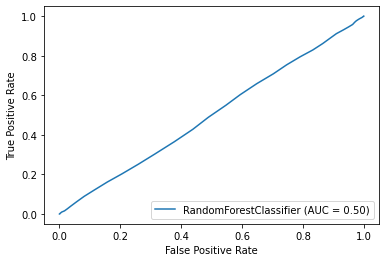

roc_auc : 49.99%


In [557]:
## AUC curve
metrics.plot_roc_curve(valid_model, x_valid_test, y_valid_test)
plt.show()

probs = valid_model.predict_proba(x_valid_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_valid_test, preds)
print("roc_auc : %.2f%%" % (metrics.auc(fpr, tpr) * 100.0))

#### The roc_auc is nearly 0.5, then we could say that the train and test data have the same distribution

# 3. Data Modeling
## 3.1 One Model: Logsitic Regression, Random Forest, KNN, XGBoost, and MLP

In [480]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sn
from math import sqrt

In [694]:
## the same train and test for Adversarial Validation
y = train6['hospital_death']
X = train6.drop(columns=['hospital_death'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [695]:
X_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72182 entries, 69481 to 82981
Data columns (total 147 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   age                            float64
 1   bmi                            float64
 2   elective_surgery               float64
 3   ethnicity                      float64
 4   gender                         float64
 5   height                         float64
 6   hospital_admit_source          float64
 7   icu_admit_source               float64
 8   icu_id                         float64
 9   icu_stay_type                  float64
 10  icu_type                       float64
 11  pre_icu_los_days               float64
 12  weight                         float64
 13  albumin_apache                 float64
 14  apache_2_diagnosis             float64
 15  apache_3j_diagnosis            float64
 16  apache_post_operative          float64
 17  arf_apache                     float64
 18  b

In [678]:
y_test.shape

(18046,)

## Logistic Regression

In [577]:
logistic_regression = LogisticRegression(max_iter=400)
logistic_regression.fit(X_train,y_train)

y_pred=logistic_regression.predict(X_test)
logis_accuracy = metrics.accuracy_score(y_test, y_pred)

In [578]:
print("Accuracy: %.2f%%" % (logis_accuracy* 100.0))

Accuracy: 92.61%


## Random Forest

In [580]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')


model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)

In [581]:
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Accuracy: %.2f%%" % (rf_accuracy * 100.0))

Accuracy: 93.08%


## KNN

### Standardized data 

In [583]:
ss = StandardScaler()
scaled_x_train = ss.fit_transform(X_train)
scaled_x_test = ss.transform(X_test)

In [584]:
from sklearn.neighbors import KNeighborsClassifier

In [585]:
knn_classifier7 = KNeighborsClassifier(n_neighbors=7)
knn_classifier7.fit(scaled_x_train, y_train)
knn_predictions = knn_classifier7.predict(scaled_x_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("Accuracy: %.2f%%" % (knn_accuracy * 100.0))

Accuracy: 92.59%


## XGBoost Model

In [588]:
import xgboost as xgb
# tune the model manually
model_XGB = xgb.XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=500,
                        learning_rate = 0.01)
eval_set = [(X_train, y_train), (X_test, y_test)]

model_XGB.fit(X_train, y_train.values.ravel(), early_stopping_rounds=15,
              eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)



[0]	validation_0-error:0.06968	validation_0-logloss:0.68525	validation_1-error:0.08439	validation_1-logloss:0.68545
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.06459	validation_0-logloss:0.67746	validation_1-error:0.07930	validation_1-logloss:0.67795
[2]	validation_0-error:0.06216	validation_0-logloss:0.66986	validation_1-error:0.07725	validation_1-logloss:0.67055
[3]	validation_0-error:0.06110	validation_0-logloss:0.66244	validation_1-error:0.07531	validation_1-logloss:0.66329
[4]	validation_0-error:0.06026	validation_0-logloss:0.65508	validation_1-error:0.07365	validation_1-logloss:0.65613
[5]	validation_0-error:0.06001	validation_0-logloss:0.64792	validation_1-error:0.07409	validation_1-logloss:0.64916
[6]	validation_0-error:0.05965	validation_0-logloss:0.64087	validation_1-error:0.07359	validation_1-logloss:0.64233
[7]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.33,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [590]:
xgb_redictions = model_XGB.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("Accuracy: %.2f%%" % (xgb_accuracy * 100.0))


Accuracy: 93.20%


## Neural Network

### Standardize data --  the same as KNN

In [520]:
from sklearn.neural_network import MLPClassifier

#use the same scaled data for KNN
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(scaled_x_train, y_train.values.ravel())

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)

In [521]:
mlp_predictions = mlp.predict(scaled_x_test)

In [522]:
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print("Accuracy: %.2f%%" % (mlp_accuracy * 100.0))

Accuracy: 92.62%


## 3.2 Many Models: Logistic Regression, Random Forest, KNN, XGBoost, MLP

In [703]:
## use the same dataset as one model
train7 = train6.copy()

### 3.2.1 Check correlation between age and other varibles

In [700]:
## check correlation between age and other variales
x_many_train.corr()

## age has low correaltion with all other variables

age       bmi  elective_surgery  \
age                            1.000000 -0.082206          0.067047   
bmi                           -0.082206  1.000000          0.012761   
elective_surgery               0.067047  0.012761          1.000000   
ethnicity                      0.027955 -0.024335          0.020580   
gender                        -0.026387 -0.049313          0.028905   
height                        -0.111818 -0.063842          0.019539   
hospital_admit_source          0.041228  0.016406          0.532400   
icu_admit_source               0.069902  0.026678          0.639568   
icu_id                        -0.028835  0.002105         -0.051458   
icu_stay_type                 -0.008379  0.002469         -0.058208   
icu_type                      -0.073374 -0.023140         -0.112173   
pre_icu_los_days               0.051946 -0.001510          0.130467   
weight                        -0.123162  0.874057          0.022367   
albumin_apache                -0.071651  0.028118         -0.016080   
apache_2_diagnosis             0.023783  0.023154          0.366946   
apache_3j_diagnosis            0.001877 -0.003078         -0.001698   
apache_post_operative          0.057464  0.011948          0.908551   
arf_apache                     0.002191 -0.004395         -0.028366   
bilirubin_apache              -0.038686 -0.003005         -0.048768   
bun_apache                     0.209187  0.054581         -0.135450   
creatinine_apache              0.052223  0.062276         -0.087604   
fio2_apache                   -0.001242  0.000502          0.001594   
gcs_eyes_apache                0.028428  0.012627          0.011757   
gcs_motor_apache               0.026666  0.021698          0.016989   
gcs_unable_apache             -0.007405  0.005246          0.016835   
gcs_verbal_apache             -0.016245  0.024961         -0.011815   
glucose_apache                 0.009701  0.094017         -0.024982   
heart_rate_apache             -0.152201 -0.023868         -0.073404   
hematocrit_apache             -0.103152  0.080288         -0.112970   
intubated_apache               0.012010  0.033278          0.162528   
map_apache                    -0.015395  0.055437         -0.005236   
paco2_apache                   0.019813  0.100738         -0.004210   
paco2_for_ph_apache            0.019813  0.100738         -0.004210   
pao2_apache                   -0.000938 -0.041177          0.055872   
ph_apache                      0.021250 -0.028509          0.025896   
resprate_apache                0.039433  0.007637         -0.142705   
sodium_apache                  0.030525 -0.016925          0.046179   
temp_apache                   -0.079517  0.040800         -0.041111   
urineoutput_apache            -0.126570  0.027522         -0.005202   
ventilated_apache              0.037856  0.066773          0.146064   
wbc_apache                    -0.011618  0.029188          0.073341   
d1_diasbp_invasive_max        -0.074109  0.033463          0.066575   
d1_diasbp_invasive_min        -0.109519  0.023022          0.020979   
d1_diasbp_max                 -0.061307  0.053148         -0.194160   
d1_diasbp_min                 -0.212075 -0.014947          0.002963   
d1_diasbp_noninvasive_max     -0.058580  0.053465         -0.184979   
d1_diasbp_noninvasive_min     -0.209160 -0.015191          0.012860   
d1_heartrate_max              -0.137112 -0.032951         -0.077630   
d1_heartrate_min              -0.143031  0.013572         -0.027799   
d1_mbp_invasive_max           -0.010834  0.015966          0.009976   
d1_mbp_invasive_min           -0.051674 -0.003801          0.021274   
d1_mbp_max                     0.006781  0.062350         -0.146371   
d1_mbp_min                    -0.131078  0.012134          0.007427   
d1_mbp_noninvasive_max         0.006541  0.062859         -0.150825   
d1_mbp_noninvasive_min        -0.129202  0.012498          0.016389   
d1_resprate_max                0.033826  0.007463         -0

In [722]:
## keep the target variable in train and test for convinience in dividing groups
training_dataset,test_dataset = train_test_split(train7, train_size=0.8, test_size=0.2, random_state=1)

In [712]:
training_dataset.info(), test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72182 entries, 69481 to 82981
Columns: 148 entries, hospital_death to apache_2_bodysystem
dtypes: float64(146), int64(2)
memory usage: 82.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18046 entries, 59958 to 2207
Columns: 148 entries, hospital_death to apache_2_bodysystem
dtypes: float64(146), int64(2)
memory usage: 20.5 MB


(None, None)

In [743]:
training_dataset.describe()

hospital_death           age           bmi  elective_surgery  \
count    72182.000000  72182.000000  72182.000000      72182.000000   
mean         0.082140     62.251171     29.278746          0.189105   
std          0.274579     16.784374      8.165934          0.391595   
min          0.000000     16.000000     14.844926          0.000000   
25%          0.000000     52.000000     23.898422          0.000000   
50%          0.000000     65.000000     27.830679          0.000000   
75%          0.000000     75.000000     32.851562          0.000000   
max          1.000000     89.000000     67.814990          1.000000   

          ethnicity        gender        height  hospital_admit_source  \
count  72182.000000  72182.000000  72182.000000           72182.000000   
mean       1.977571      0.544845    169.815974               4.221052   
std        0.980156      0.497988     10.680866               2.885015   
min        0.000000      0.000000    137.200000               0.000000   
25%        2.000000      0.000000    162.600000               3.000000   
50%        2.000000      1.000000    170.100000               3.000000   
75%        2.000000      1.000000    177.800000               4.000000   
max        5.000000      1.000000    195.590000              14.000000   

       icu_admit_source        icu_id  ...  apache_4a_hospital_death_prob  \
count      72182.000000  72182.000000  ...                   72182.000000   
mean           0.695894    531.813665  ...                       0.077062   
std            0.933466    247.923647  ...                       0.235675   
min            0.000000     82.000000  ...                      -1.000000   
25%            0.000000    376.000000  ...                       0.010000   
50%            0.000000    513.000000  ...                       0.040000   
75%            1.000000    694.000000  ...                       0.110000   
max            4.000000   1111.000000  ...                       0.990000   

       apache_4a_icu_death_prob  diabetes_mellitus  hepatic_failure  \
count              72182.000000       72182.000000     72182.000000   
mean                   0.039731           0.228991         0.013508   
std                    0.207241           0.420186         0.115435   
min                   -1.000000           0.000000         0.000000   
25%                    0.010000           0.000000         0.000000   
50%                    0.020000           0.000000         0.000000   
75%                    0.050000           0.000000         0.000000   
max                    0.970000           1.000000         1.000000   

       immunosuppression      leukemia      lymphoma  \
count       72182.000000  72182.000000  72182.000000   
mean            0.026918      0.007135      0.004267   
std             0.161845      0.084166      0.065183   
min             0.000000      0.000000      0.000000   
25%             0.000000      0.000000      0.000000   
50%             0.000000      0.000000      0.000000   
75%             0.000000      0.000000      0.000000   
max             1.000000      1.000000      1.000000   

       solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  
count                 72182.000000          72182.000000         72182.000000  
mean                      0.020767              4.331662             2.626015  
std                       0.142604              3.836087             2.876585  
min                       0.000000              0.000000             0.000000  
25%                       0.000000              0.000000             0.000000  
50%                       0.000000              5.000000             1.000000  
75%                       0.000000              8.000000             5.000000  
max                       1.000000             11.000000            10.000000  

[8 rows x 148 columns]

### 3.2.2 Define a new complete y_test for later comparison

In [768]:
## make a new complete y_test according to the age order, so that will fit the train dataset
y_50 = test_dataset[test_dataset['age'] <50].hospital_death
y_56 = test_dataset[(test_dataset['age'] >=50) & (test_dataset['age'] <60)].hospital_death
y_67 = test_dataset[(test_dataset['age'] >= 60) & (test_dataset['age'] <70)].hospital_death
y_78 = test_dataset[(test_dataset['age'] >= 70) & (test_dataset['age'] <80)].hospital_death
y_81 = test_dataset[(test_dataset['age'] >= 80) & (test_dataset['age'] <100)].hospital_death
y_whole_test = np.concatenate((y_50,y_56,y_67,y_78,y_81),axis=0)

In [774]:
len(y_whole_test)

18046

### 3.2.3 Divide groups

In [724]:
## dividing function
def split_xy(dataset, number1, number2=None):
    if (number2 == None):
        group = dataset[(dataset.age <number1)]
        target = group['hospital_death']
        group = group.drop(columns = ['age','hospital_death'])
        
    else:
        group = dataset[(dataset.age >=number1) & (dataset.age < number2)]
        target = group['hospital_death']
        group = group.drop(columns = ['age','hospital_death'])
    
    return group, target

In [742]:
X_group1_train, y_group1_train = split_xy(training_dataset, 50)
X_group1_test, y_group1_test = split_xy(test_dataset, 50)
X_group1_train.shape, y_group1_train.shape, X_group1_test.shape, y_group1_test.shape

((14922, 146), (14922,), (3719, 146), (3719,))

In [814]:
X_group2_train,y_group2_train = split_xy(training_dataset, 50,60)
X_group2_test,y_group2_test =  split_xy(test_dataset, 50,60)
X_group2_train.shape, X_group2_test.shape, y_group2_train.shape, y_group2_test.shape

((13229, 146), (3257, 146), (13229,), (3257,))

In [738]:
X_group3_train,y_group3_train = split_xy(training_dataset, 60,70)
X_group3_test,y_group3_test =  split_xy(test_dataset, 60,70)
X_group3_train.shape, X_group3_test.shape, y_group3_train.shape, y_group3_test.shape

((16551, 146), (4132, 146), (16551,), (4132,))

In [739]:
X_group4_train,y_group4_train = split_xy(training_dataset, 70,80)
X_group4_test,y_group4_test =  split_xy(test_dataset, 70,80)
X_group4_train.shape, X_group4_test.shape, y_group4_train.shape, y_group4_test.shape

((15916, 146), (4069, 146), (15916,), (4069,))

In [816]:
X_group5_train,y_group5_train = split_xy(training_dataset, 80,100)
X_group5_test,y_group5_test =  split_xy(test_dataset, 80,100)
X_group5_train.shape, X_group5_test.shape, y_group5_train.shape, y_group5_test.shape

((11564, 146), (2869, 146), (11564,), (2869,))

In [741]:
3719+3257+4132+4069+2869

18046

## Logistic Regression

In [757]:
def logis_modeling(xtrain, ytrain, xtest):
    logistic_regression = LogisticRegression(max_iter=400)
    logistic_regression.fit(xtrain,ytrain)
    y_pred = logistic_regression.predict(xtest)
    
    return y_pred

In [777]:
pred_array1= logis_modeling(X_group1_train, y_group1_train, X_group1_test)
pred_array2=logis_modeling(X_group2_train, y_group2_train, X_group2_test)
pred_array3=logis_modeling(X_group3_train, y_group3_train, X_group3_test)
pred_array4=logis_modeling(X_group4_train, y_group4_train, X_group4_test)
pred_array5=logis_modeling(X_group5_train, y_group5_train, X_group5_test)

In [778]:
logis_final_predictions = np.concatenate((pred_array1,pred_array2,pred_array3,pred_array4,pred_array5),axis=0)
len(logis_final_predictions)

18046

In [779]:
## we got the df of the predictions
## then we have to compare it with original y_test
logis_many_accuracy = metrics.accuracy_score(y_whole_test,logis_final_predictions)
print("Accuracy: %.2f%%" % (logis_many_accuracy * 100.0))

Accuracy: 92.52%


## Random Forest 

In [780]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
def rf_modeling(xtrain,ytrain,xtest):
    model = RandomForestClassifier(n_estimators=728,
                                  min_samples_split= 5,
                                  min_samples_leaf= 2,
                                  max_features='auto',
                                  max_depth= 10,
                                  bootstrap=True)

    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    
    return y_pred

In [781]:
pred_array1= rf_modeling(X_group1_train, y_group1_train, X_group1_test)
pred_array2=rf_modeling(X_group2_train, y_group2_train, X_group2_test)
pred_array3=rf_modeling(X_group3_train, y_group3_train, X_group3_test)
pred_array4=rf_modeling(X_group4_train, y_group4_train, X_group4_test)
pred_array5=rf_modeling(X_group5_train, y_group5_train, X_group5_test)

In [782]:
rf_final_predictions = np.concatenate((pred_array1,pred_array2,pred_array3,pred_array4,pred_array5),axis=0)
len(rf_final_predictions)
rf_many_accuracy = metrics.accuracy_score(y_whole_test,final_predictions)
print("Accuracy: %.2f%%" % (rf_many_accuracy * 100.0))

Accuracy: 92.85%


## KNN 

### Standardize data

In [794]:
ss = StandardScaler()
def scale(train,test):
    scaled_x_train = ss.fit_transform(train)
    scaled_x_test = ss.transform(test)
    return scaled_x_train, scaled_x_test

In [819]:
scaled_x_train1, scaled_x_test1 = scale(X_group1_train, X_group1_test)
scaled_x_train2, scaled_x_test2 = scale(X_group2_train, X_group2_test)
scaled_x_train3, scaled_x_test3 = scale(X_group3_train, X_group3_test)
scaled_x_train4, scaled_x_test4 = scale(X_group4_train, X_group4_test)
scaled_x_train5, scaled_x_test5 = scale(X_group5_train, X_group5_test)

In [783]:
## use the model with neighbors 7
def knn_modeling(xtrain,ytrain,xtest):
    knn_classifier = KNeighborsClassifier(n_neighbors=7)
    knn_classifier.fit(xtrain, ytrain)
    y_pred = knn_classifier.predict(xtest)
    
    return y_pred

In [820]:
pred_array1=knn_modeling(scaled_x_train1, y_group1_train, scaled_x_test1)
pred_array2=knn_modeling(scaled_x_train2, y_group2_train, scaled_x_test2)
pred_array3=knn_modeling(scaled_x_train3, y_group3_train, scaled_x_test3)
pred_array4=knn_modeling(scaled_x_train4, y_group4_train, scaled_x_test4)
pred_array5=knn_modeling(scaled_x_train5, y_group5_train, scaled_x_test5)

In [821]:
knn_final_predictions = np.concatenate((pred_array1,pred_array2,pred_array3,pred_array4,pred_array5),axis=0)
len(knn_final_predictions)
knn_many_accuracy = accuracy_score(y_whole_test, knn_final_predictions)
print("Accuracy: %.2f%%" % (knn_many_accuracy * 100.0))

Accuracy: 92.43%


## XGBoost

In [829]:
def xgb_modeling(xtrain, ytrain,xtest, ytest):
    xgb_model = xgb.XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.01)
    
    eval_set = [(xtrain, ytrain), (xtest, ytest)]

    xgb_model.fit(xtrain, ytrain.values.ravel(), early_stopping_rounds=15,
              eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

    y_pred = xgb_model.predict(xtest)
    
    return y_pred

In [830]:
pred_array1=xgb_modeling(X_group1_train, y_group1_train, X_group1_test, y_group1_test)
pred_array2=xgb_modeling(X_group2_train, y_group2_train, X_group2_test, y_group2_test)
pred_array3=xgb_modeling(X_group3_train, y_group3_train, X_group3_test, y_group3_test)
pred_array4=xgb_modeling(X_group4_train, y_group4_train, X_group4_test, y_group4_test)
pred_array5=xgb_modeling(X_group5_train, y_group5_train, X_group5_test, y_group5_test)
xgb_final_predictions = np.concatenate((pred_array1,pred_array2,pred_array3,pred_array4,pred_array5),axis=0)

[0]	validation_0-error:0.03954	validation_0-logloss:0.68433	validation_1-error:0.04759	validation_1-logloss:0.68442
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.03284	validation_0-logloss:0.67567	validation_1-error:0.03764	validation_1-logloss:0.67587
[2]	validation_0-error:0.03297	validation_0-logloss:0.66720	validation_1-error:0.03791	validation_1-logloss:0.66747
[3]	validation_0-error:0.03197	validation_0-logloss:0.65891	validation_1-error:0.03711	validation_1-logloss:0.65930
[4]	validation_0-error:0.03116	validation_0-logloss:0.65072	validation_1-error:0.03657	validation_1-logloss:0.65117
[5]	validation_0-error:0.03250	validation_0-logloss:0.64270	validation_1-error:0.03603	validation_1-logloss:0.64331
[6]	validation_0-error:0.03170	validation_0-logloss:0.63481	validation_1-error:0.03738	validation_1-logloss:0.63550
[7]	validation_0-error:

In [832]:
xgb_many_accuracy = accuracy_score(y_whole_test, xgb_final_predictions)
print("Accuracy: %.2f%%" % (xgb_many_accuracy * 100.0))

Accuracy: 92.93%


## Neural Network

In [806]:
def mlp_modeling(xtrain, ytrain,xtest):
    mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
    mlp.fit(xtrain, ytrain.values.ravel())
    
    y_pred = mlp.predict(xtest)
    return y_pred

In [822]:
## still need to use the scaled data
pred_array1=mlp_modeling(scaled_x_train1, y_group1_train, scaled_x_test1)
pred_array2=mlp_modeling(scaled_x_train2, y_group2_train, scaled_x_test2)
pred_array3=mlp_modeling(scaled_x_train3, y_group3_train, scaled_x_test3)
pred_array4=mlp_modeling(scaled_x_train4, y_group4_train, scaled_x_test4)
pred_array5=mlp_modeling(scaled_x_train5, y_group5_train, scaled_x_test5)
mlp_final_predictions = np.concatenate((pred_array1,pred_array2,pred_array3,pred_array4,pred_array5),axis=0)

In [823]:
mlp_many_accuracy = accuracy_score(y_whole_test, mlp_final_predictions)
print("Accuracy: %.2f%%" % (mlp_many_accuracy * 100.0))

Accuracy: 90.55%


# 4. Scoreboard

In [835]:
from prettytable import PrettyTable

scoreboard = PrettyTable()
scoreboard.field_names = ["Model", "One-Model Approach", "Many-Model Approach"]
scoreboard.add_row(["Logistic", round(logis_accuracy,3), round(logis_many_accuracy,3)])
scoreboard.add_row(["Random Forest", round(rf_accuracy,3), round(rf_many_accuracy,3)])
scoreboard.add_row(["KNN", round(knn_accuracy,3), round(knn_many_accuracy,3)])
scoreboard.add_row(["XGBoost", round(xgb_accuracy,3), round(xgb_many_accuracy,3)])
scoreboard.add_row(["MLP", round(mlp_accuracy,3), round(mlp_many_accuracy,3)])

print(scoreboard)

+---------------+--------------------+---------------------+
|     Model     | One-Model Approach | Many-Model Approach |
+---------------+--------------------+---------------------+
|    Logistic   |       0.926        |        0.925        |
| Random Forest |       0.931        |        0.928        |
|      KNN      |       0.926        |        0.924        |
|    XGBoost    |       0.932        |        0.929        |
|      MLP      |       0.926        |        0.905        |
+---------------+--------------------+---------------------+


# 5. Discussion

From the scoreboar we could tell that there is no big difference between One-Model and Many-Model approaches, 
no matter using which model. To be exact, the One-Model approach has higher accuracy than Many-Model approach.
And One-Model approach saves time and energy. However, One-Model approach may lead to overfitting easily, 
especially for the data distributes very skewedly. Therefore, applying a model on each subgroups may be helpful
in detecting difference among subgroups and deciding whether the result from One-Model approach is overfitting.

# References

1. https://scikit-learn.org/
2. https://pandas.pydata.org/pandas-docs
3. https://www.kaggle.com/jayjay75/wids2020-lgb-starter-adversarial-validation
4. https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc